In [1]:
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error, mean_absolute_error
import pandas as pd
import gc
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import torch.nn.functional as F
from torchsummary import summary
from torchtsmixer.CTFT_TSMixer_GR import CTFT_TSMixer_GR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

hist_step = 100
pred_step = 1
input_channel = 3
output_channel = 6

model = CTFT_TSMixer_GR(sequence_length = hist_step, prediction_length = pred_step, input_channels = input_channel, output_channels = output_channel, 
                        tft_d_model = 64, tft_heads = 4, tft_layers = 2, tft_dropout = 0.3, 
                        num_blocks = 4, mixer_dropout = 0.3, ff_dim = 128,
                        num_nodes = 6, graph_hidden_dim = 32)
model = model.to(device=device)

cuda


In [2]:
import os
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

current_dir = os.getcwd()

parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, "TestSet")
print(f"Data directory: {data_dir}")

scaler_dir = os.path.join(current_dir, "Scaler")
print(f"Scaler directory: {scaler_dir}")

X_seq_test = np.load(os.path.join(data_dir, "X_seq_test.npy"))
X_static_test = np.load(os.path.join(data_dir, "X_static_test.npy"))
Y_test = np.load(os.path.join(data_dir, "Y_test.npy"))

print("Test set:", X_seq_test.shape, X_static_test.shape, Y_test.shape)

def load_minmax_scaler(path):
    data = np.load(path)
    return data["min_val"], data["max_val"]

X_seq_min, X_seq_max = load_minmax_scaler(
    os.path.join(scaler_dir, "X_seq_minmax_scaler.npz")
)
X_static_min, X_static_max = load_minmax_scaler(
    os.path.join(scaler_dir, "X_static_minmax_scaler.npz")
)
Y_min, Y_max = load_minmax_scaler(
    os.path.join(scaler_dir, "Y_static_minmax_scaler.npz")
)

def apply_minmax(x, min_val, max_val):
    return (x - min_val) / (max_val - min_val + 1e-8)

X_seq_test_flat = X_seq_test.reshape(-1, X_seq_test.shape[-1])
X_seq_test_norm = apply_minmax(X_seq_test_flat, X_seq_min, X_seq_max)
X_seq_test_norm = X_seq_test_norm.reshape(X_seq_test.shape)

X_static_test_norm = apply_minmax(X_static_test, X_static_min, X_static_max)
Y_test_norm = apply_minmax(Y_test, Y_min, Y_max)

case_dir = os.path.join(data_dir, "test_cases")
test_data_per_case = {}

if not os.path.isdir(case_dir):
    raise FileNotFoundError(f"Test condition catalog not found: {case_dir}")

case_ids = []
for fn in os.listdir(case_dir):
    if fn.startswith("X_seq_case") and fn.endswith(".npy"):
        cid = int(fn.replace("X_seq_case", "").replace(".npy", ""))
        case_ids.append(cid)
case_ids = sorted(case_ids)

for cid in case_ids:
    X_seq_case = np.load(os.path.join(case_dir, f"X_seq_case{cid}.npy"))
    X_static_case = np.load(os.path.join(case_dir, f"X_static_case{cid}.npy"))
    Y_case = np.load(os.path.join(case_dir, f"Y_case{cid}.npy"))

    test_data_per_case[cid] = (X_seq_case, X_static_case, Y_case)

print(f"✅ test_data_per_case : {len(test_data_per_case)} test case")

test_data_per_case_norm = {}

for cid, (X_seq_case, X_static_case, Y_case) in test_data_per_case.items():

    X_seq_flat = X_seq_case.reshape(-1, X_seq_case.shape[-1])
    X_seq_case_norm = apply_minmax(X_seq_flat, X_seq_min, X_seq_max)
    X_seq_case_norm = X_seq_case_norm.reshape(X_seq_case.shape)

    X_static_case_norm = apply_minmax(X_static_case, X_static_min, X_static_max)
    Y_case_norm = apply_minmax(Y_case, Y_min, Y_max)

    X_seq_case_norm = X_seq_case_norm.reshape(-1, 100, 2)
    X_static_case_norm = X_static_case_norm.reshape(-1, 1)

    X_case_norm = torch.cat(
        [
            torch.tensor(X_seq_case_norm, dtype=torch.float32),
            torch.tensor(X_static_case_norm, dtype=torch.float32)
            .unsqueeze(1)
            .expand(-1, 100, -1),
        ],
        dim=-1,
    )

    test_data_per_case_norm[cid] = (X_case_norm, Y_case_norm)

print("✅ test_data_per_case_norm established")

X_seq_test_t = torch.tensor(X_seq_test_norm, dtype=torch.float32)
X_static_test_t = torch.tensor(X_static_test_norm, dtype=torch.float32)
Y_test_t = torch.tensor(Y_test_norm, dtype=torch.float32)

test_X = torch.cat(
    [X_seq_test_t, X_static_test_t.unsqueeze(1).expand(-1, 100, -1)],
    dim=-1,
)

test_dataset = TensorDataset(test_X, Y_test_t)

batch_size = 256
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)

Data directory: d:\0DATA\NHRI\Python Code\4、代理模型_水深预测\GitHub\上传 - 1.5\TestSet
Scaler directory: d:\0DATA\NHRI\Python Code\4、代理模型_水深预测\GitHub\上传 - 1.5\2_CTFT_TSMixer_GR\Scaler
Test set: (13006, 100, 2) (13006, 1) (13006, 6)
✅ test_data_per_case : 9 test case
✅ test_data_per_case_norm established


In [3]:
Y_min_t = torch.tensor(Y_min, dtype=torch.float32, device=device)   
Y_max_t = torch.tensor(Y_max, dtype=torch.float32, device=device)   
Y_range_t = (Y_max_t - Y_min_t).clamp_min(1e-8)                   

In [4]:
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

current_dir = os.getcwd()
data_dir = os.path.join(current_dir, "Best_PINN_CTFT_TSMixer_GR.pth") 
print(f"Data directory: {data_dir}")

best_model = torch.load(data_dir, weights_only = False)

Data directory: d:\0DATA\NHRI\Python Code\4、代理模型_水深预测\GitHub\上传 - 1.5\2_CTFT_TSMixer_GR\Best_PINN_CTFT_TSMixer_GR.pth


In [5]:
print(model)

CTFT_TSMixer_GR(
  (tft): CompactTFT(
    (input_proj): Linear(in_features=3, out_features=64, bias=True)
    (pos_encoding): PositionalEncoding()
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=128, bias=True)
          (dropout): Dropout(p=0.3, inplace=False)
          (linear2): Linear(in_features=128, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.3, inplace=False)
          (dropout2): Dropout(p=0.3, inplace=False)
        )
      )
    )
    (static_fuse): GRN(
      (fc1): Linear(in_features=64, out_features=128, bias=True)
      (fc2): Linear(in_features=1

In [6]:
import numpy as np

def median_absolute_error(y_true, y_pred):
    """
    Median Absolute Error (MdAE)
    """
    errors = np.abs(y_true - y_pred)
    return np.median(errors)

def iqr_based_mae(y_true, y_pred):
    errors = np.abs(y_true - y_pred).flatten() 
    q1 = np.percentile(errors, 25)
    q3 = np.percentile(errors, 75)
    mask = (errors >= q1) & (errors <= q3)
    filtered_errors = errors[mask]
    if len(filtered_errors) == 0:
        return np.nan  
    return np.mean(filtered_errors)


def NSE_global(y_true, y_pred, eps=1e-12):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    num = np.sum((y_true - y_pred) ** 2)
    den = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1.0 - num / (den + eps)


def R2_global(y_true, y_pred, eps=1e-12):
    return NSE_global(y_true, y_pred, eps=eps)


def NSE(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)


def hit_rate(y_true, y_pred, delta):
    relative_errors = np.abs((y_pred - y_true) / y_true) * 100 
    hits = relative_errors <= delta
    return np.mean(hits) * 100  

def KGE(y_true, y_pred):
    """Kling–Gupta Efficiency"""
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    r = np.corrcoef(y_true, y_pred)[0, 1]
    beta = np.mean(y_pred) / np.mean(y_true)
    gamma = (np.std(y_pred) / np.mean(y_pred)) / (np.std(y_true) / np.mean(y_true))
    kge = 1 - np.sqrt((r - 1)**2 + (beta - 1)**2 + (gamma - 1)**2)
    return kge

def willmott_index_modified(observed, predicted):
    """
    Willmott's Modified Index of Agreement (Willmott et al., 2012)
    """
    observed = np.array(observed)
    predicted = np.array(predicted)
    
    numerator = np.sum(np.abs(predicted - observed))
    denominator = 2 * np.sum(np.abs(observed - np.mean(observed)))
    
    if denominator == 0:
        return 1.0 if numerator == 0 else 0.0
    
    d = 1 - (numerator / denominator)
    return np.clip(d, 0, 1)

max_delta=5
deltas = np.arange(0.25, max_delta+0.25, 0.25)  # δ = 1% ~ max_delta%
print(deltas)

def evaluate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true))
    r2 = R2_global(y_true, y_pred) 
    nse = NSE_global(y_true, y_pred)  
    kge = KGE(y_true, y_pred)
    d_index = willmott_index_modified(y_true, y_pred)
    hr = [hit_rate(y_true, y_pred, d) for d in deltas]
    mdae = median_absolute_error(y_true, y_pred)
    iqr_mae = iqr_based_mae(y_true, y_pred)
    max_err = np.max(np.abs(y_true - y_pred))
    return {
        'MSE': mse, 'RMSE': rmse, 'MAPE': mape, 'MAE': mae,
        'R2': r2, 'NSE': nse, 'KGE': kge, 'd': d_index,
        'HitRate': hr, 'MdAE': mdae, 'IQR-based MAE': iqr_mae, 'MaxError': max_err
    }


[0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25 3.5
 3.75 4.   4.25 4.5  4.75 5.  ]


In [7]:
best_model = best_model.to(device)
best_model.eval()

def predict_norm(model, X_seq_norm, device):
    model.eval()
    X_seq_t = torch.tensor(X_seq_norm, dtype=torch.float32, device=device)

    with torch.no_grad():
        out = model(X_seq_t)
        out = out.squeeze(1) 
        return out.detach().cpu().numpy()

def denorm_y(y_norm, Y_min, Y_max):
    return y_norm * (Y_max - Y_min) + Y_min

print("\n===================== Test condition indicators (output first) =====================")

case_metrics = {}

for cid in sorted(test_data_per_case_norm.keys()):
    X_case_norm, Y_case_norm = test_data_per_case_norm[cid]

    y_pred_case_norm = predict_norm(best_model, X_case_norm, device)

    y_pred_case_real = denorm_y(y_pred_case_norm, Y_min, Y_max)
    y_true_case_real = denorm_y(Y_case_norm, Y_min, Y_max)

    metrics_case = evaluate_metrics(y_true_case_real, y_pred_case_real)
    case_metrics[cid] = metrics_case

    print(f"\n--- Case {cid} ---")
    for k, v in metrics_case.items():
        if k != "HitRate":
            print(f"{k}: {v:.6f}")
        else:
            hr_str = ", ".join([f"{h:.2f}" for h in v])
            print(f"HitRate(δ=1~{max_delta}%): [{hr_str}]")

print("\n===================== The metrics for the entire test set (final output) =====================")

y_pred_total_norm = predict_norm(best_model, test_X, device)

y_pred_total_real = denorm_y(y_pred_total_norm, Y_min, Y_max)
y_true_total_real = denorm_y(Y_test_norm, Y_min, Y_max)

metrics_total = evaluate_metrics(y_true_total_real, y_pred_total_real)

print("\n--- Full test set overall ---")
for k, v in metrics_total.items():
    if k != "HitRate":
        print(f"{k}: {v:.6f}")
    else:
        hr_str = ", ".join([f"{h:.2f}" for h in v])
        print(f"HitRate(δ=1~{max_delta}%): [{hr_str}]")


===================== Test condition indicators (output first) =====================


C:\Users\Administrator\AppData\Local\Temp\ipykernel_25608\3576495955.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_seq_t = torch.tensor(X_seq_norm, dtype=torch.float32, device=device)



--- Case 3 ---
MSE: 0.024157
RMSE: 0.155426
MAPE: 0.011114
MAE: 0.129093
R2: 0.345209
NSE: 0.345209
KGE: 0.867479
d: 0.582807
HitRate(δ=1~5%): [11.43, 26.65, 40.07, 52.00, 61.50, 68.65, 75.73, 83.68, 90.10, 95.87, 98.98, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00]
MdAE: 0.110754
IQR-based MAE: 0.117540
MaxError: 0.333786

--- Case 6 ---
MSE: 0.000856
RMSE: 0.029253
MAPE: 0.001613
MAE: 0.023141
R2: 0.969590
NSE: 0.969590
KGE: 0.982093
d: 0.918467
HitRate(δ=1~5%): [75.50, 98.61, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00]
MdAE: 0.019211
IQR-based MAE: 0.019914
MaxError: 0.084653


C:\Users\Administrator\AppData\Local\Temp\ipykernel_25608\3576495955.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_seq_t = torch.tensor(X_seq_norm, dtype=torch.float32, device=device)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_25608\3576495955.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_seq_t = torch.tensor(X_seq_norm, dtype=torch.float32, device=device)



--- Case 13 ---
MSE: 0.013127
RMSE: 0.114572
MAPE: 0.009058
MAE: 0.102744
R2: 0.721759
NSE: 0.721759
KGE: 0.797816
d: 0.719771
HitRate(δ=1~5%): [5.45, 19.87, 39.72, 56.54, 77.89, 92.82, 96.46, 98.03, 99.37, 99.94, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00]
MdAE: 0.101961
IQR-based MAE: 0.101960
MaxError: 0.286205

--- Case 15 ---
MSE: 0.005993
RMSE: 0.077414
MAPE: 0.004783
MAE: 0.061077
R2: 0.776717
NSE: 0.776717
KGE: 0.946325
d: 0.783042
HitRate(δ=1~5%): [36.71, 58.82, 74.48, 88.67, 96.50, 99.54, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00]
MdAE: 0.048596
IQR-based MAE: 0.052463
MaxError: 0.199152

--- Case 22 ---
MSE: 0.021060
RMSE: 0.145122
MAPE: 0.011830
MAE: 0.135666
R2: 0.337762
NSE: 0.337762
KGE: 0.847544
d: 0.526535
HitRate(δ=1~5%): [3.64, 9.17, 15.20, 31.41, 54.29, 75.25, 90.16, 97.30, 99.46, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 10

C:\Users\Administrator\AppData\Local\Temp\ipykernel_25608\3576495955.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_seq_t = torch.tensor(X_seq_norm, dtype=torch.float32, device=device)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_25608\3576495955.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_seq_t = torch.tensor(X_seq_norm, dtype=torch.float32, device=device)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_25608\3576495955.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_seq_t = torch.tensor(X_seq_norm, dtyp


--- Case 38 ---
MSE: 0.003659
RMSE: 0.060486
MAPE: 0.003599
MAE: 0.051494
R2: 0.907917
NSE: 0.907917
KGE: 0.929689
d: 0.847802
HitRate(δ=1~5%): [33.76, 70.49, 96.42, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00]
MdAE: 0.052235
IQR-based MAE: 0.051858
MaxError: 0.136046

--- Case 42 ---
MSE: 0.008917
RMSE: 0.094429
MAPE: 0.004499
MAE: 0.077386
R2: 0.830352
NSE: 0.830352
KGE: 0.944943
d: 0.791807
HitRate(δ=1~5%): [34.29, 60.83, 79.21, 95.87, 99.53, 99.71, 99.91, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00]
MdAE: 0.068977
IQR-based MAE: 0.069963
MaxError: 0.315378

===================== The metrics for the entire test set (final output) =====================


C:\Users\Administrator\AppData\Local\Temp\ipykernel_25608\3576495955.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_seq_t = torch.tensor(X_seq_norm, dtype=torch.float32, device=device)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_25608\3576495955.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_seq_t = torch.tensor(X_seq_norm, dtype=torch.float32, device=device)



--- Full test set overall ---
MSE: 0.009241
RMSE: 0.096131
MAPE: 0.005830
MAE: 0.075866
R2: 0.997904
NSE: 0.997904
KGE: 0.974540
d: 0.978979
HitRate(δ=1~5%): [30.89, 53.66, 69.71, 81.31, 89.67, 94.62, 96.88, 98.23, 99.09, 99.67, 99.92, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00]
MdAE: 0.063129
IQR-based MAE: 0.065560
MaxError: 0.333786


C:\Users\Administrator\AppData\Local\Temp\ipykernel_25608\3576495955.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_seq_t = torch.tensor(X_seq_norm, dtype=torch.float32, device=device)


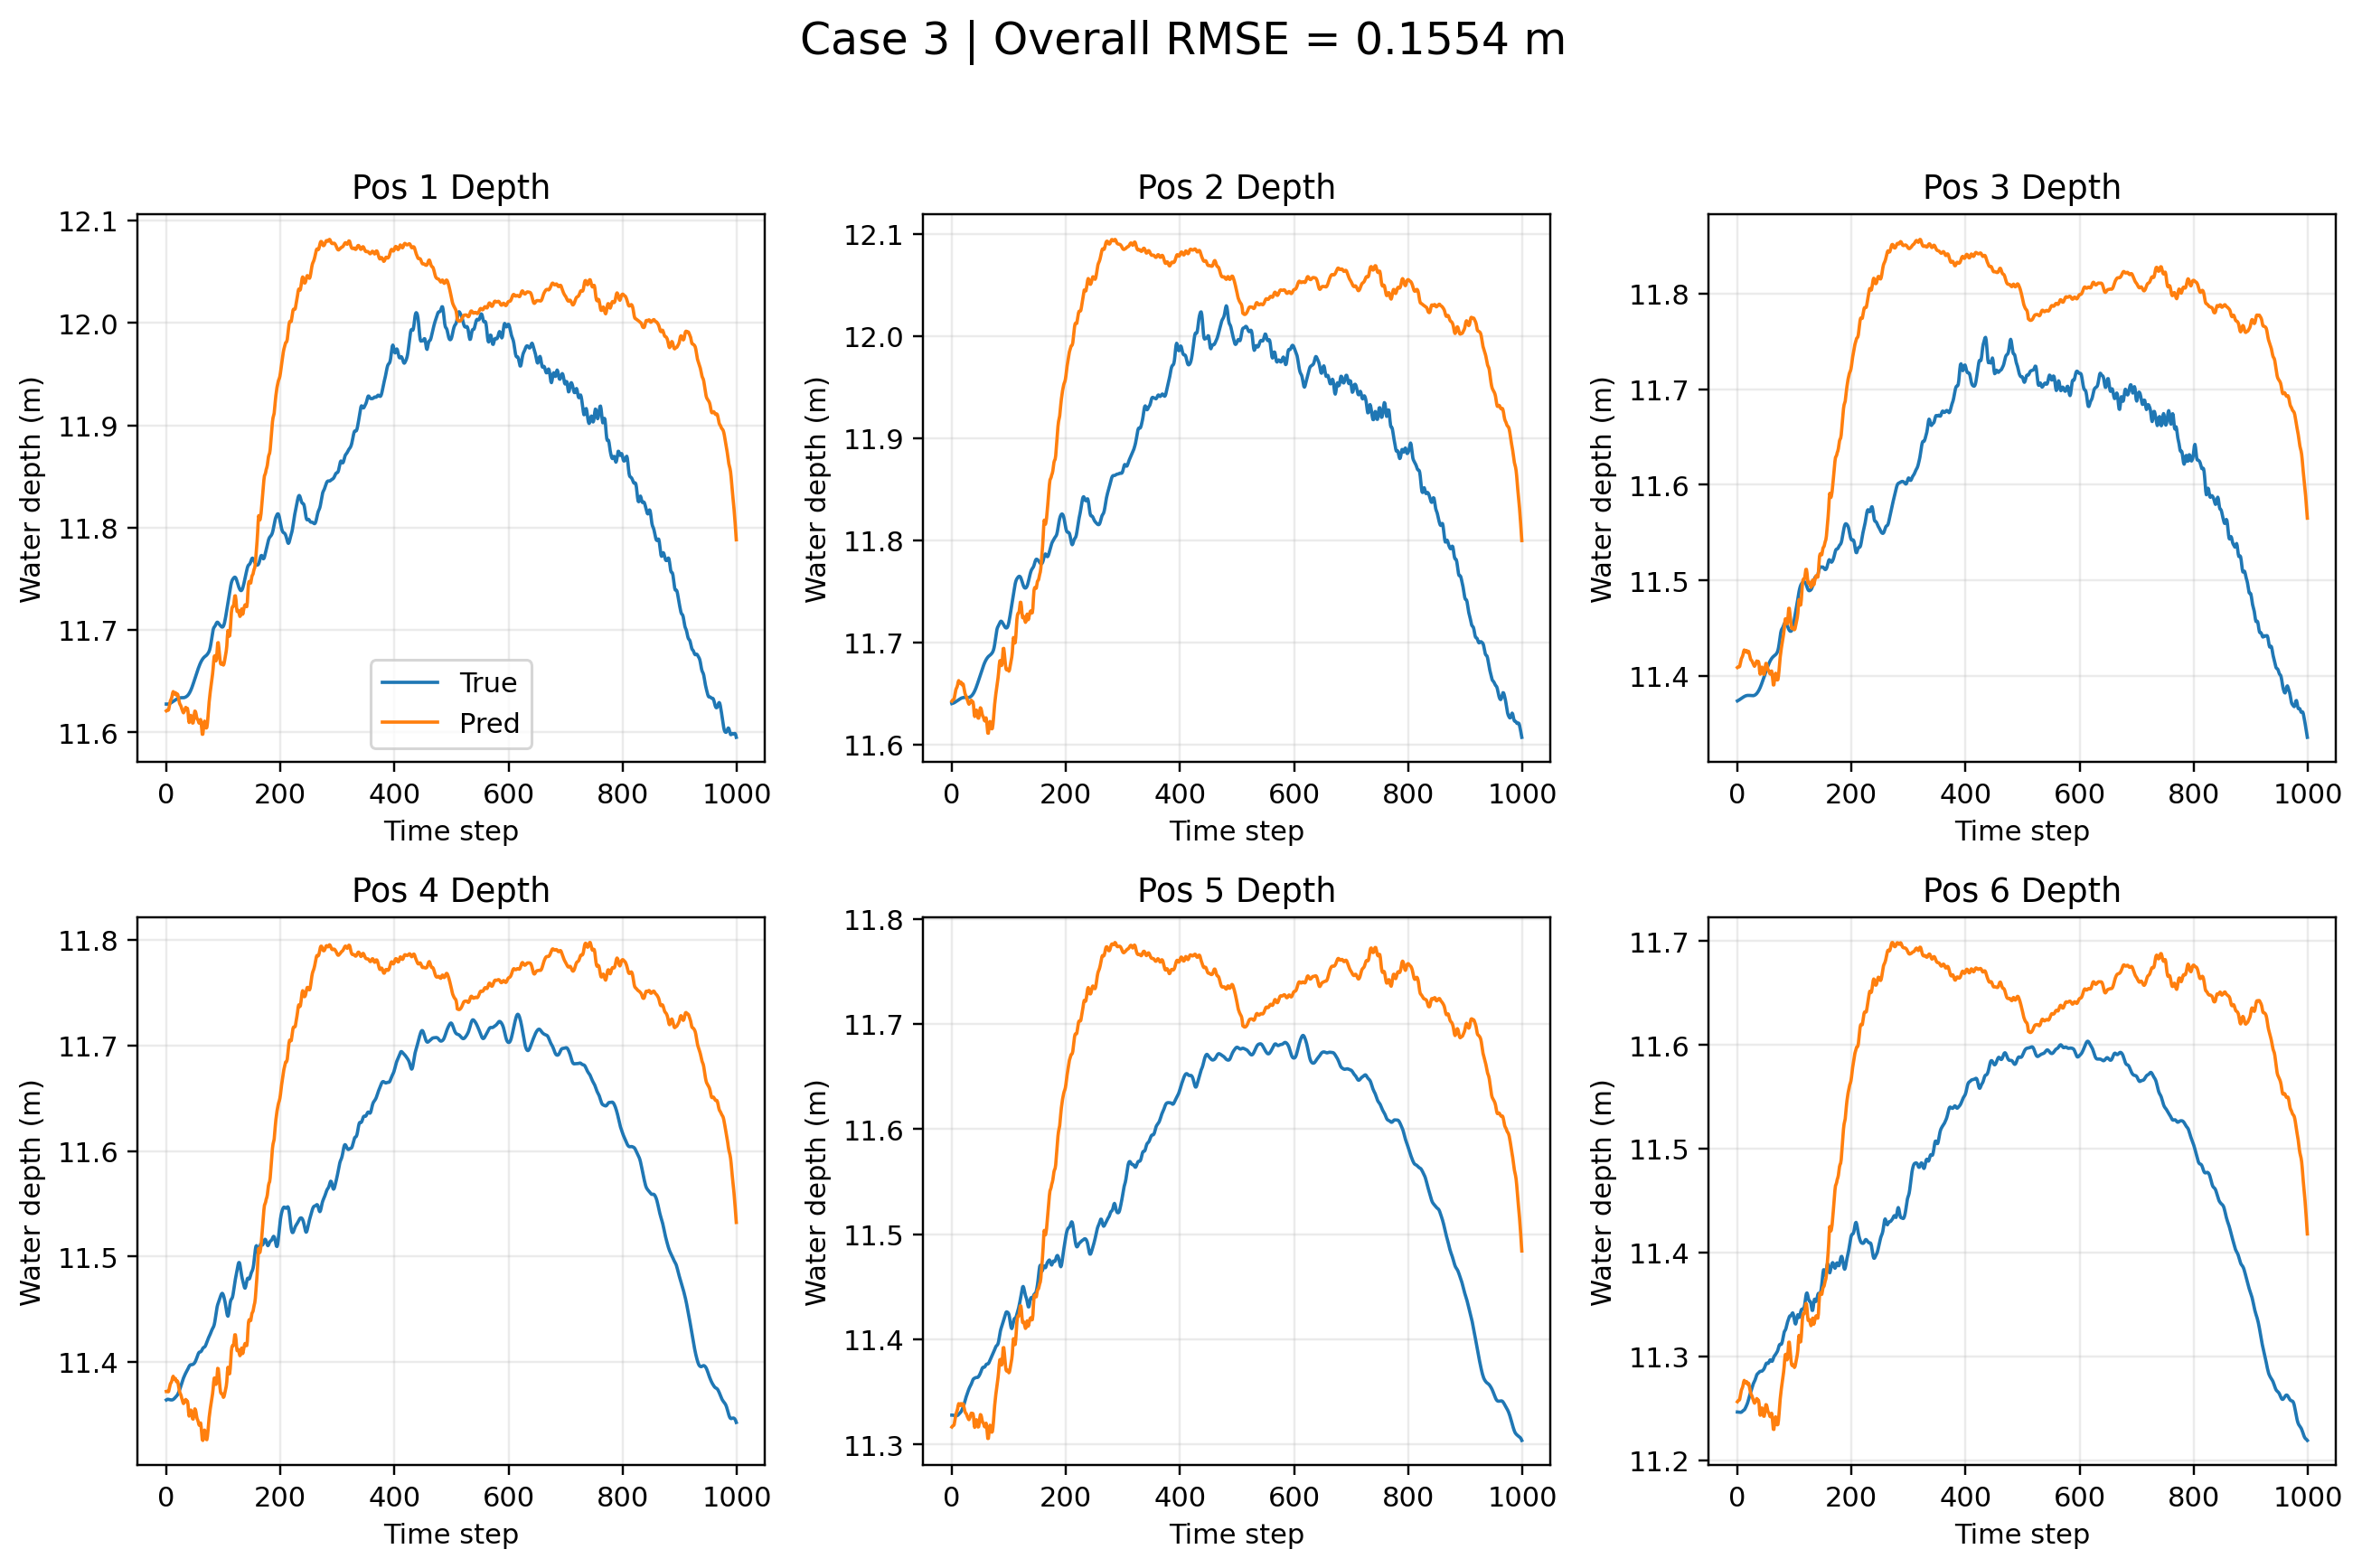

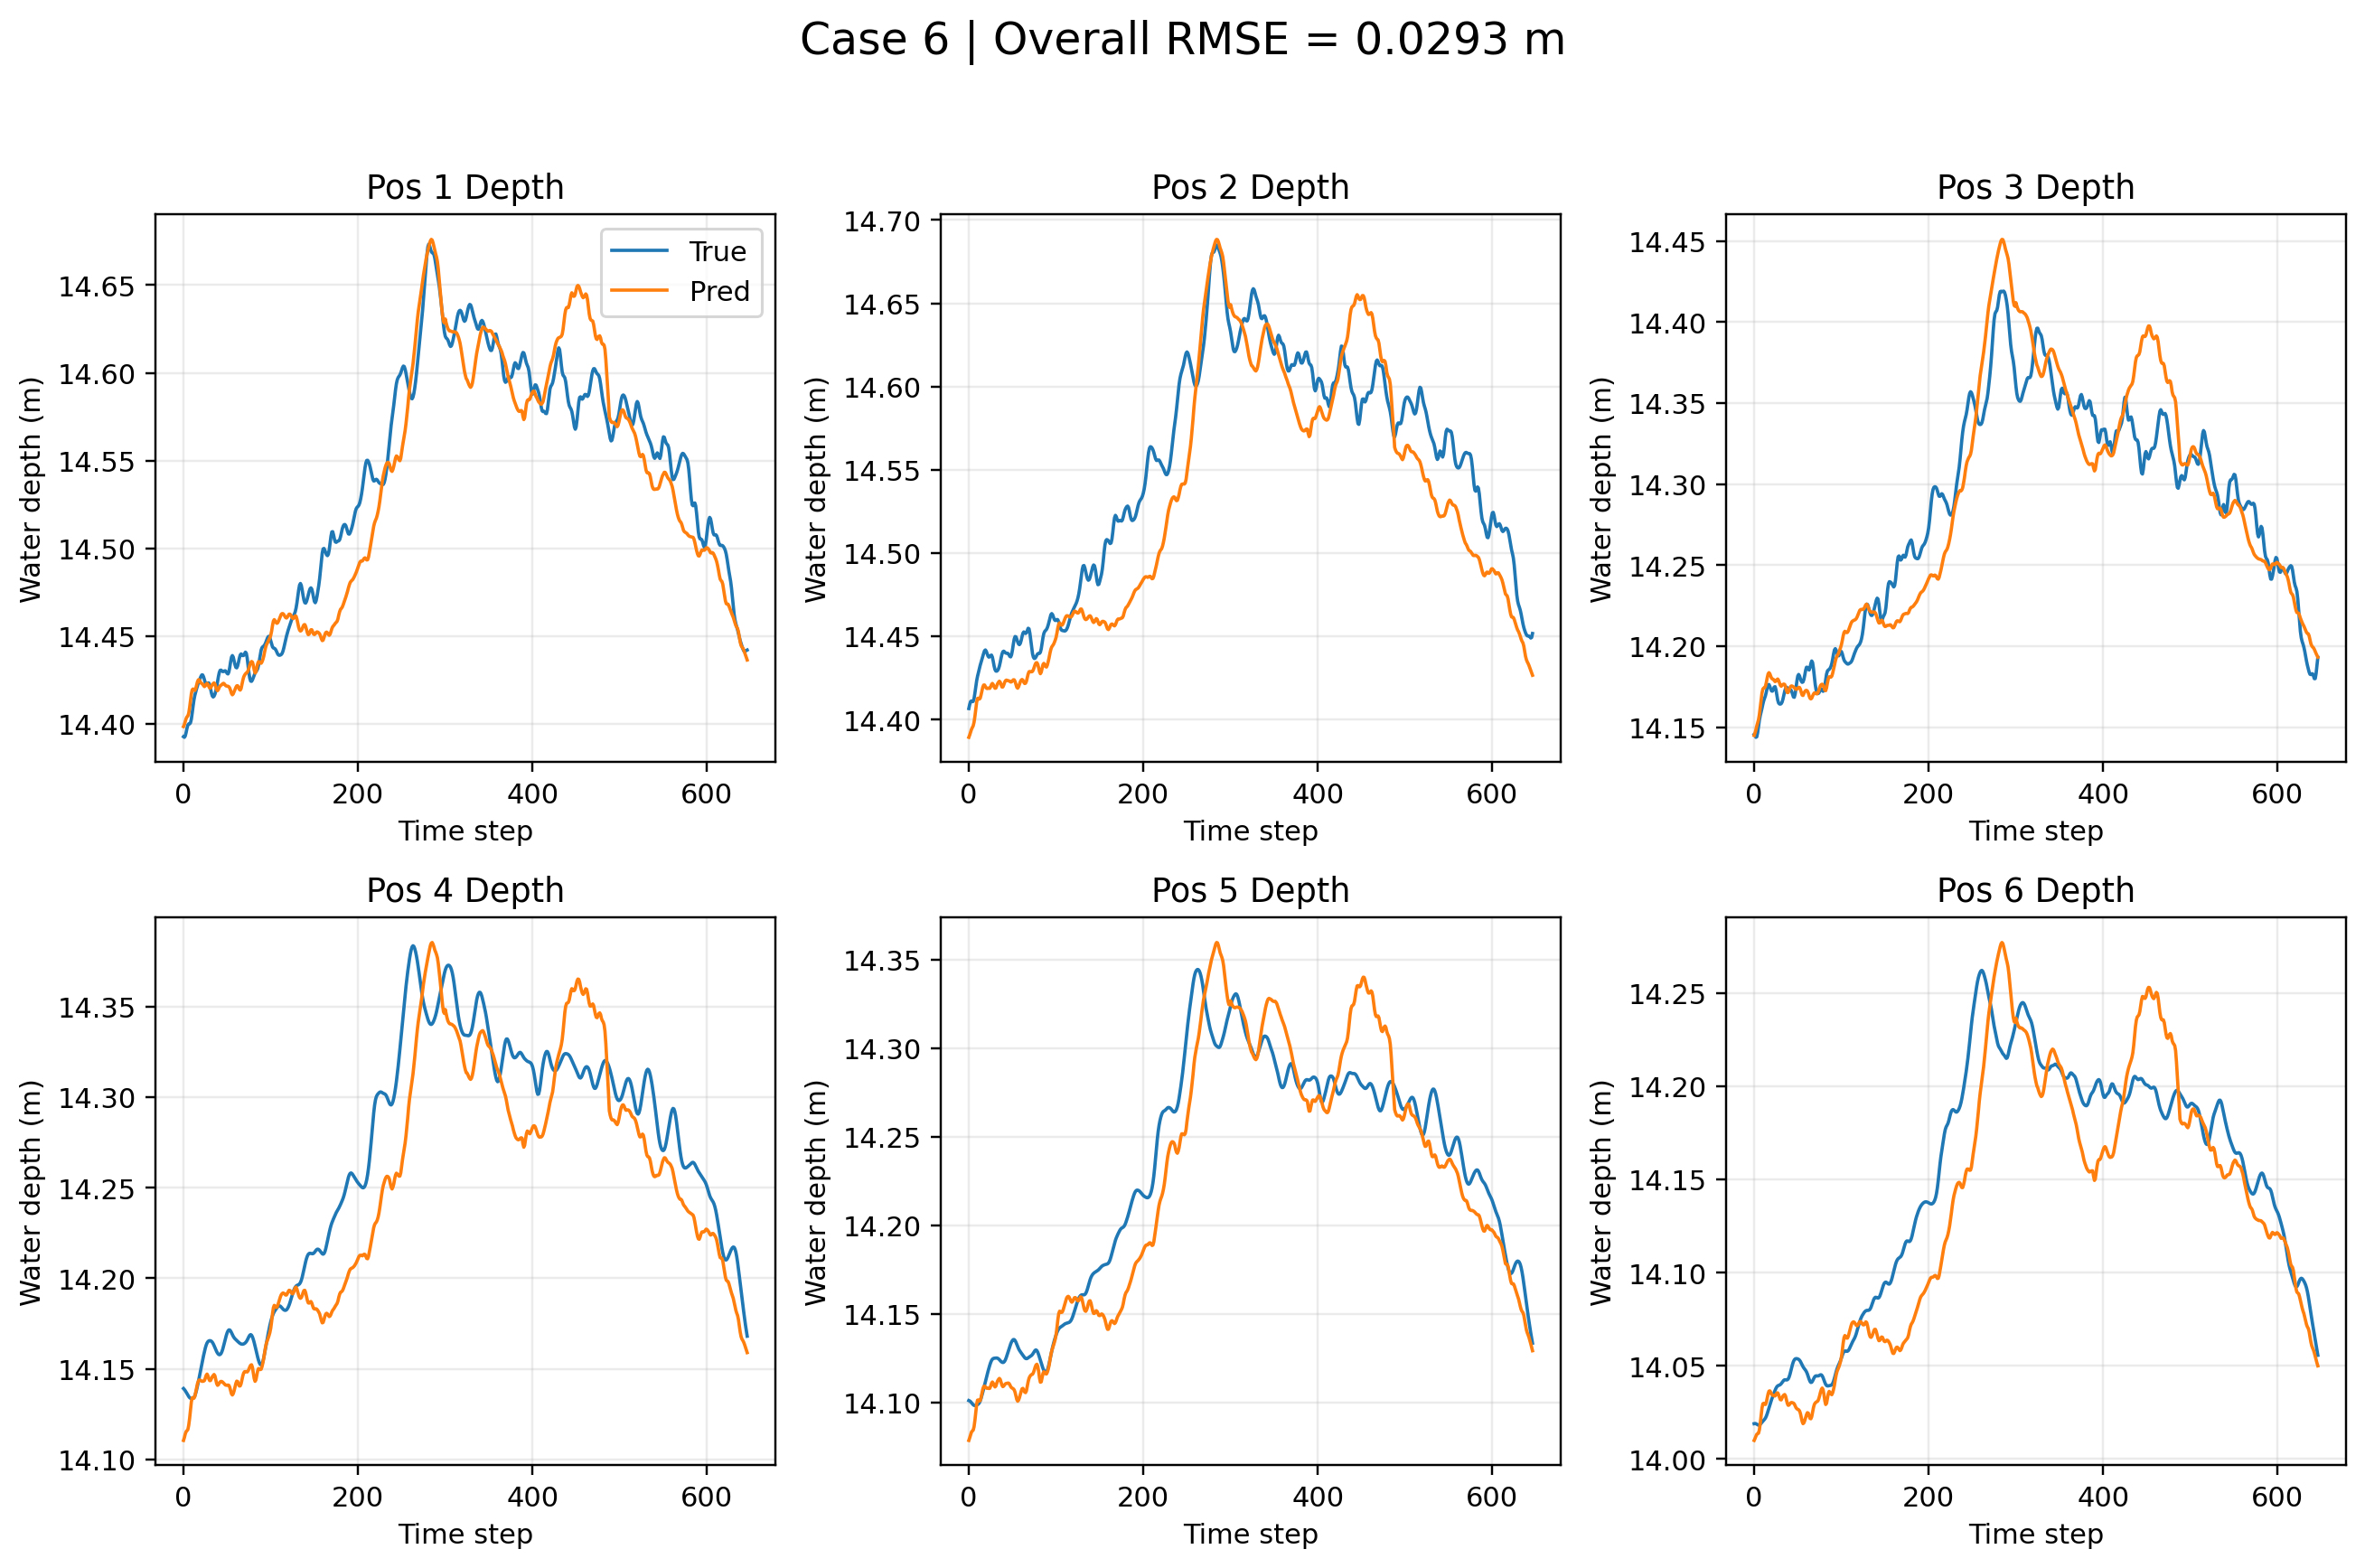

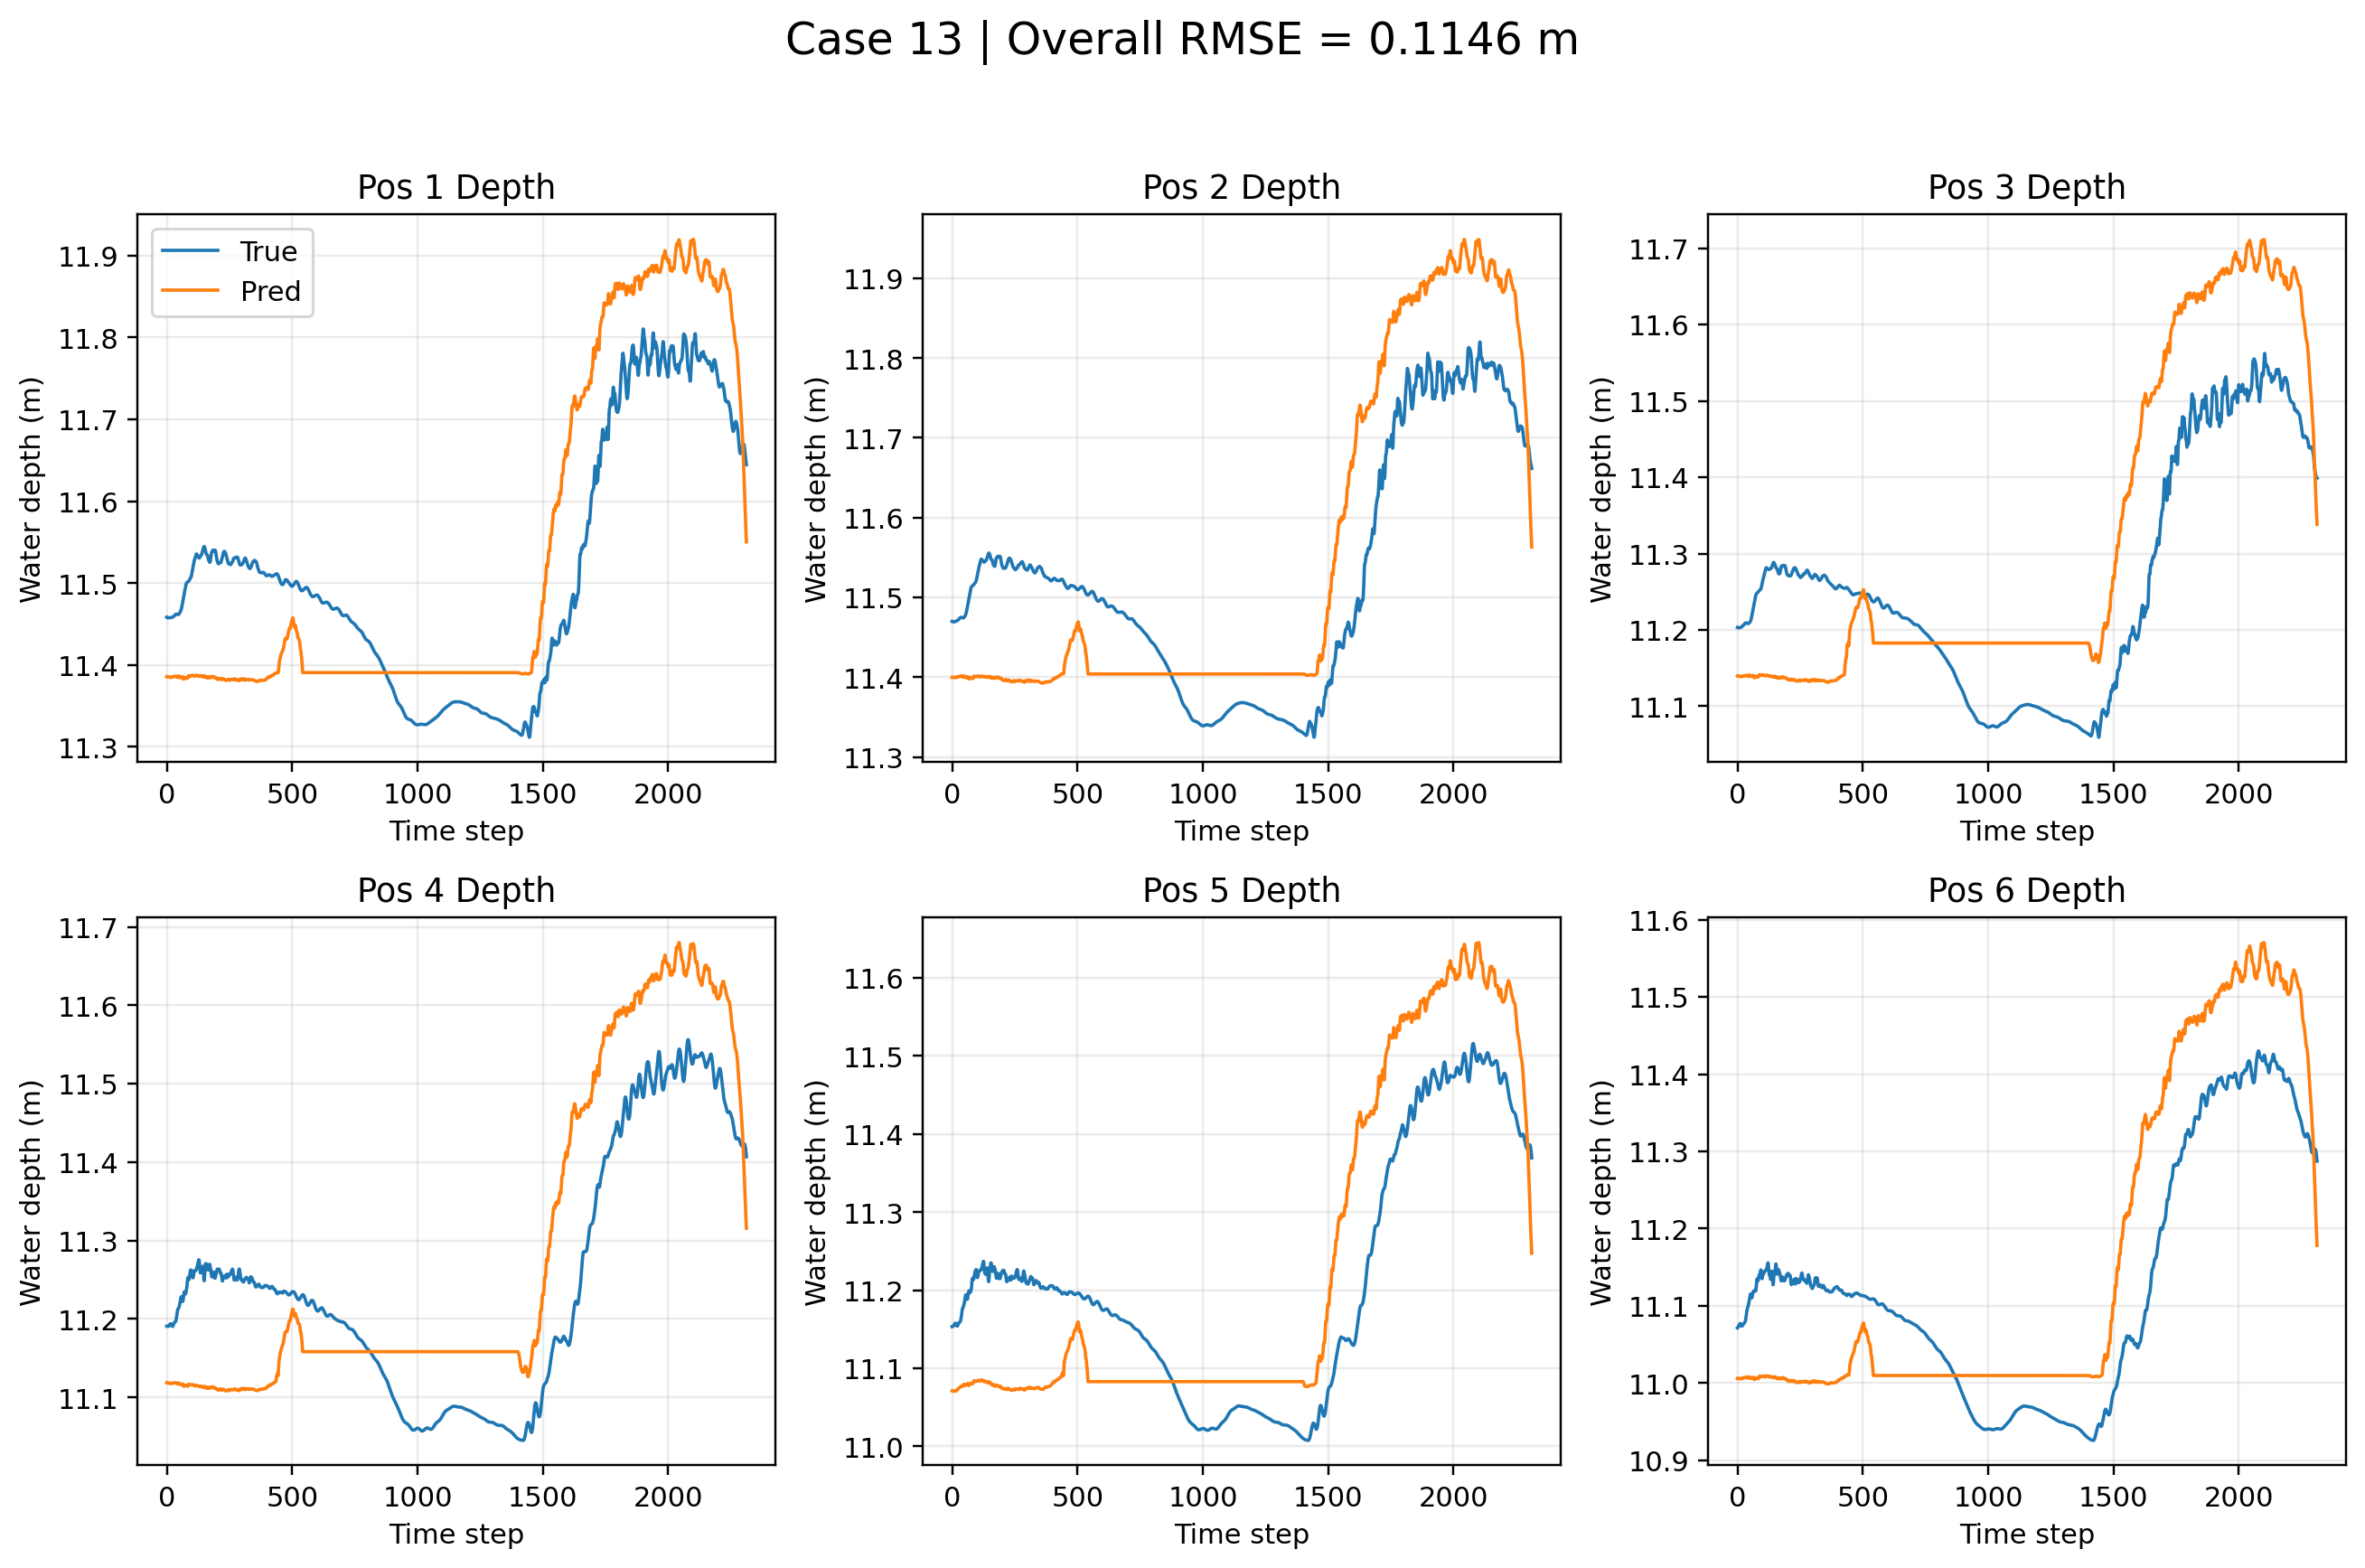

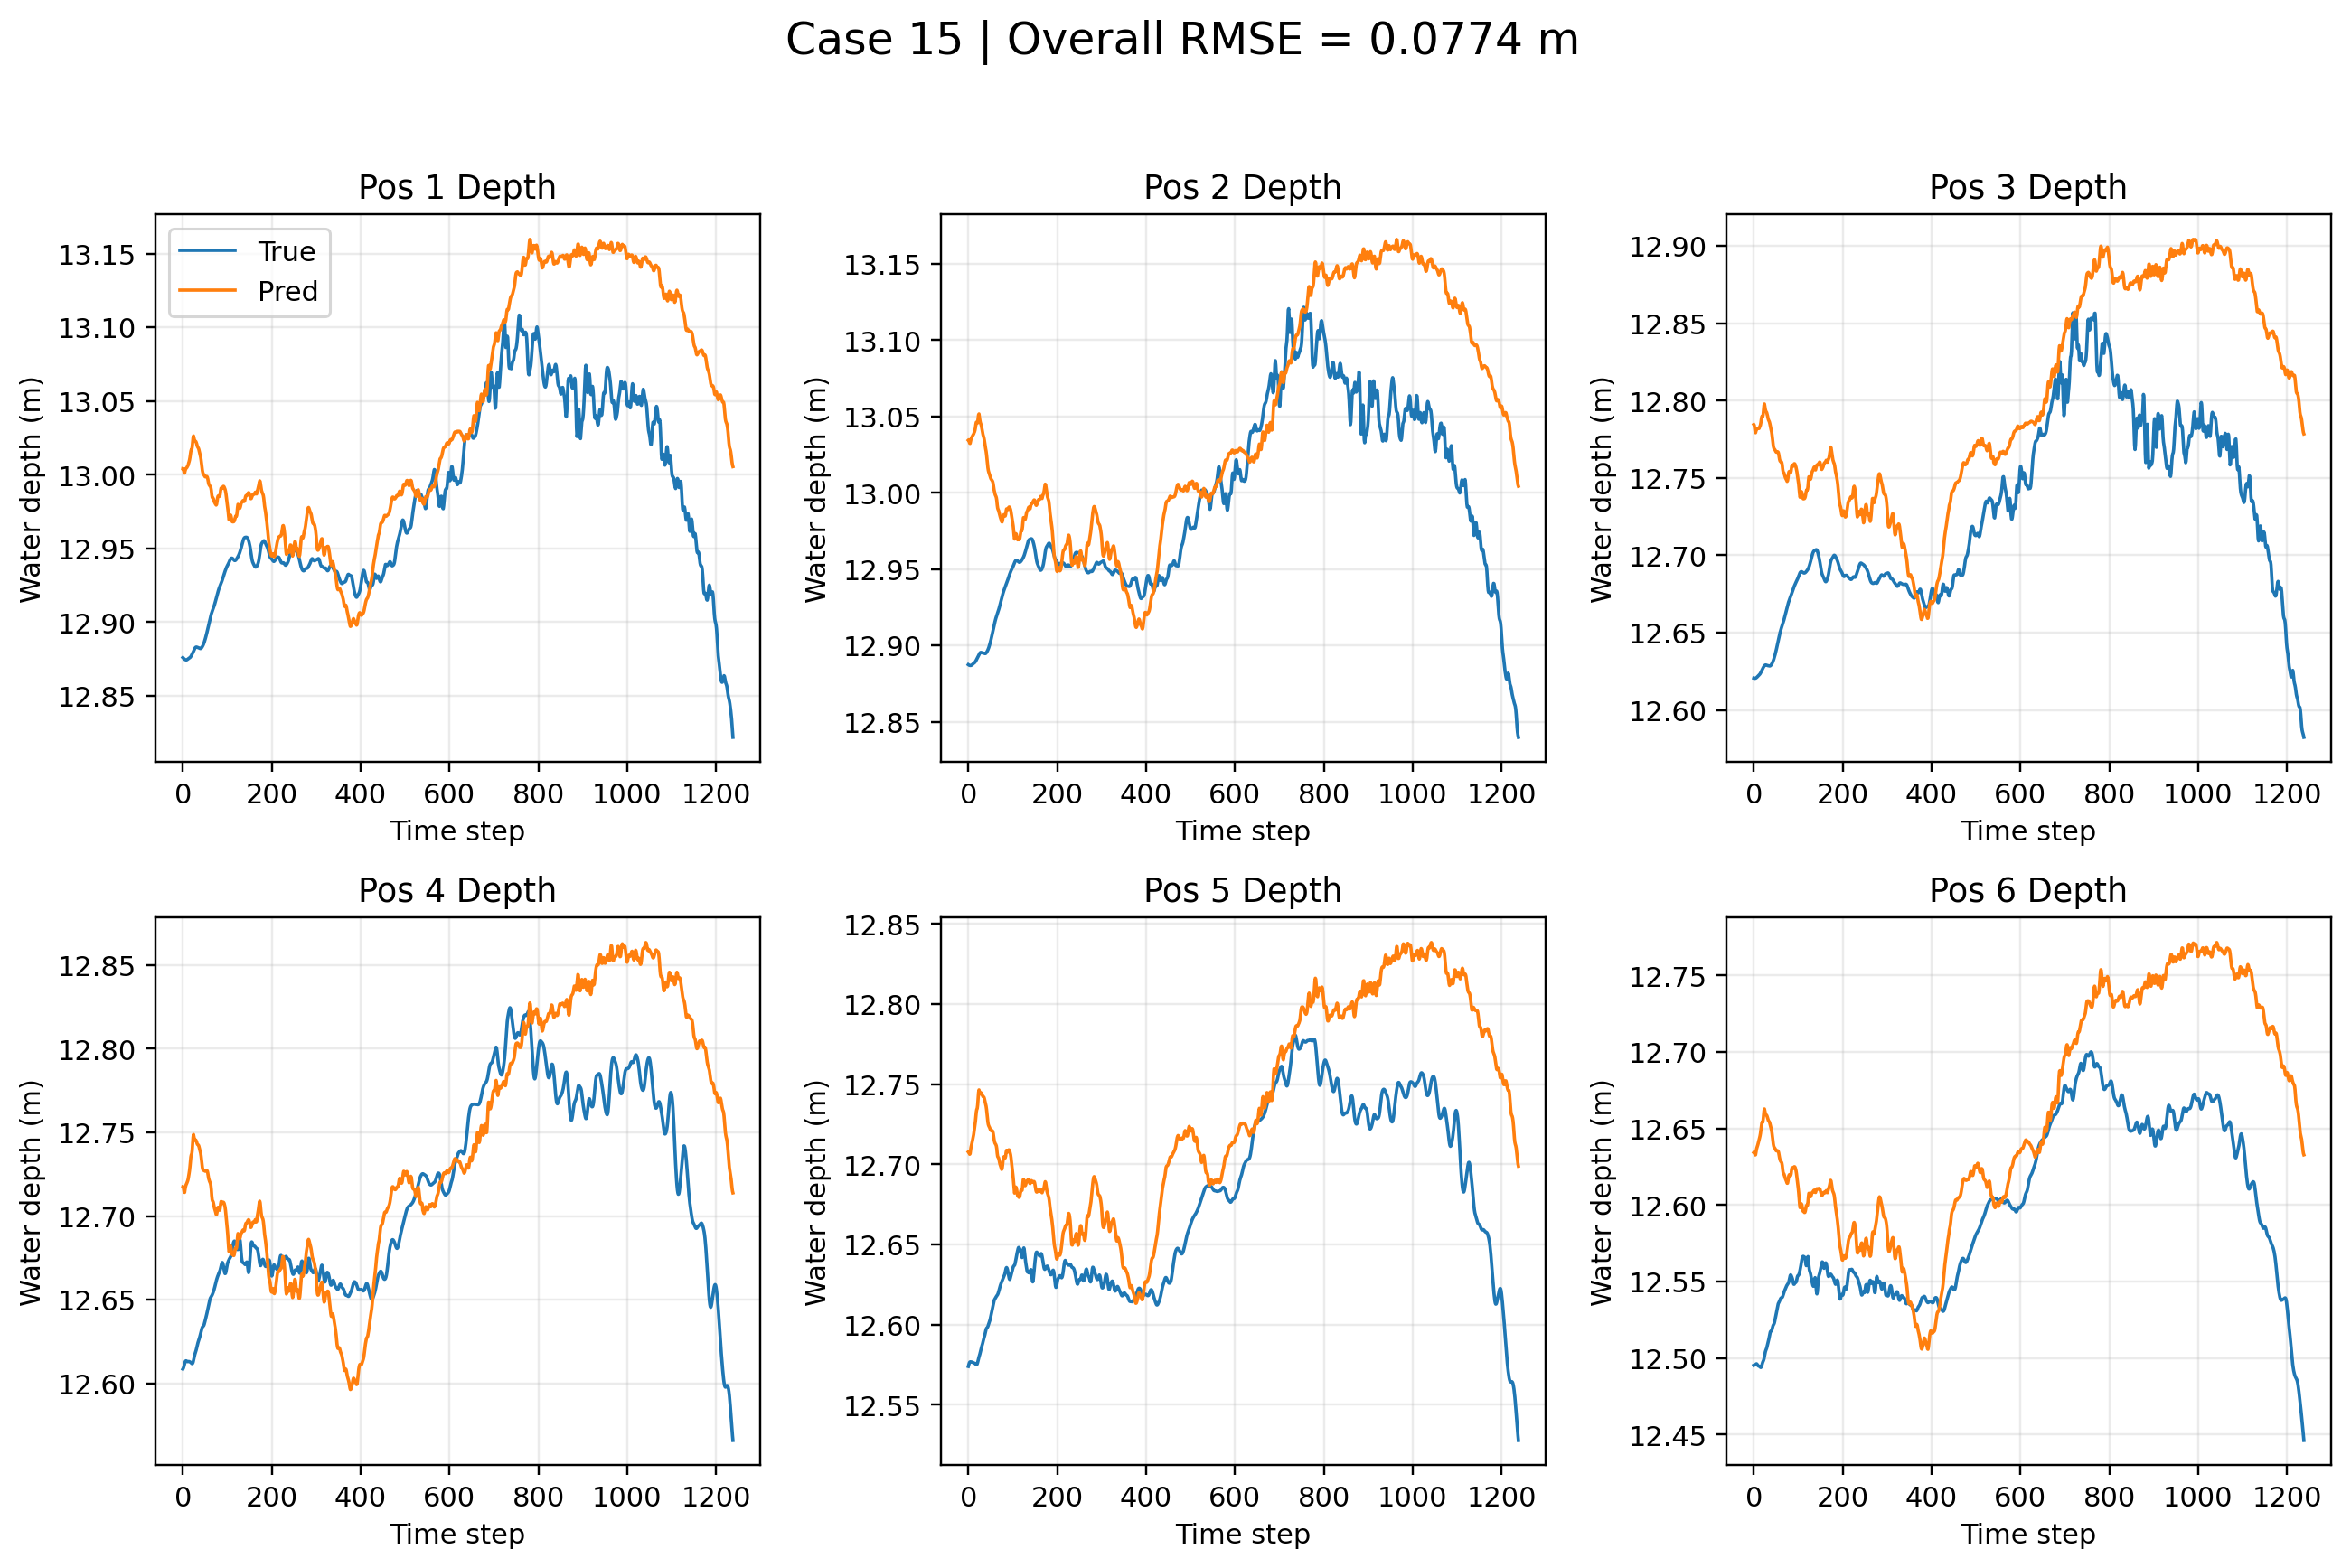

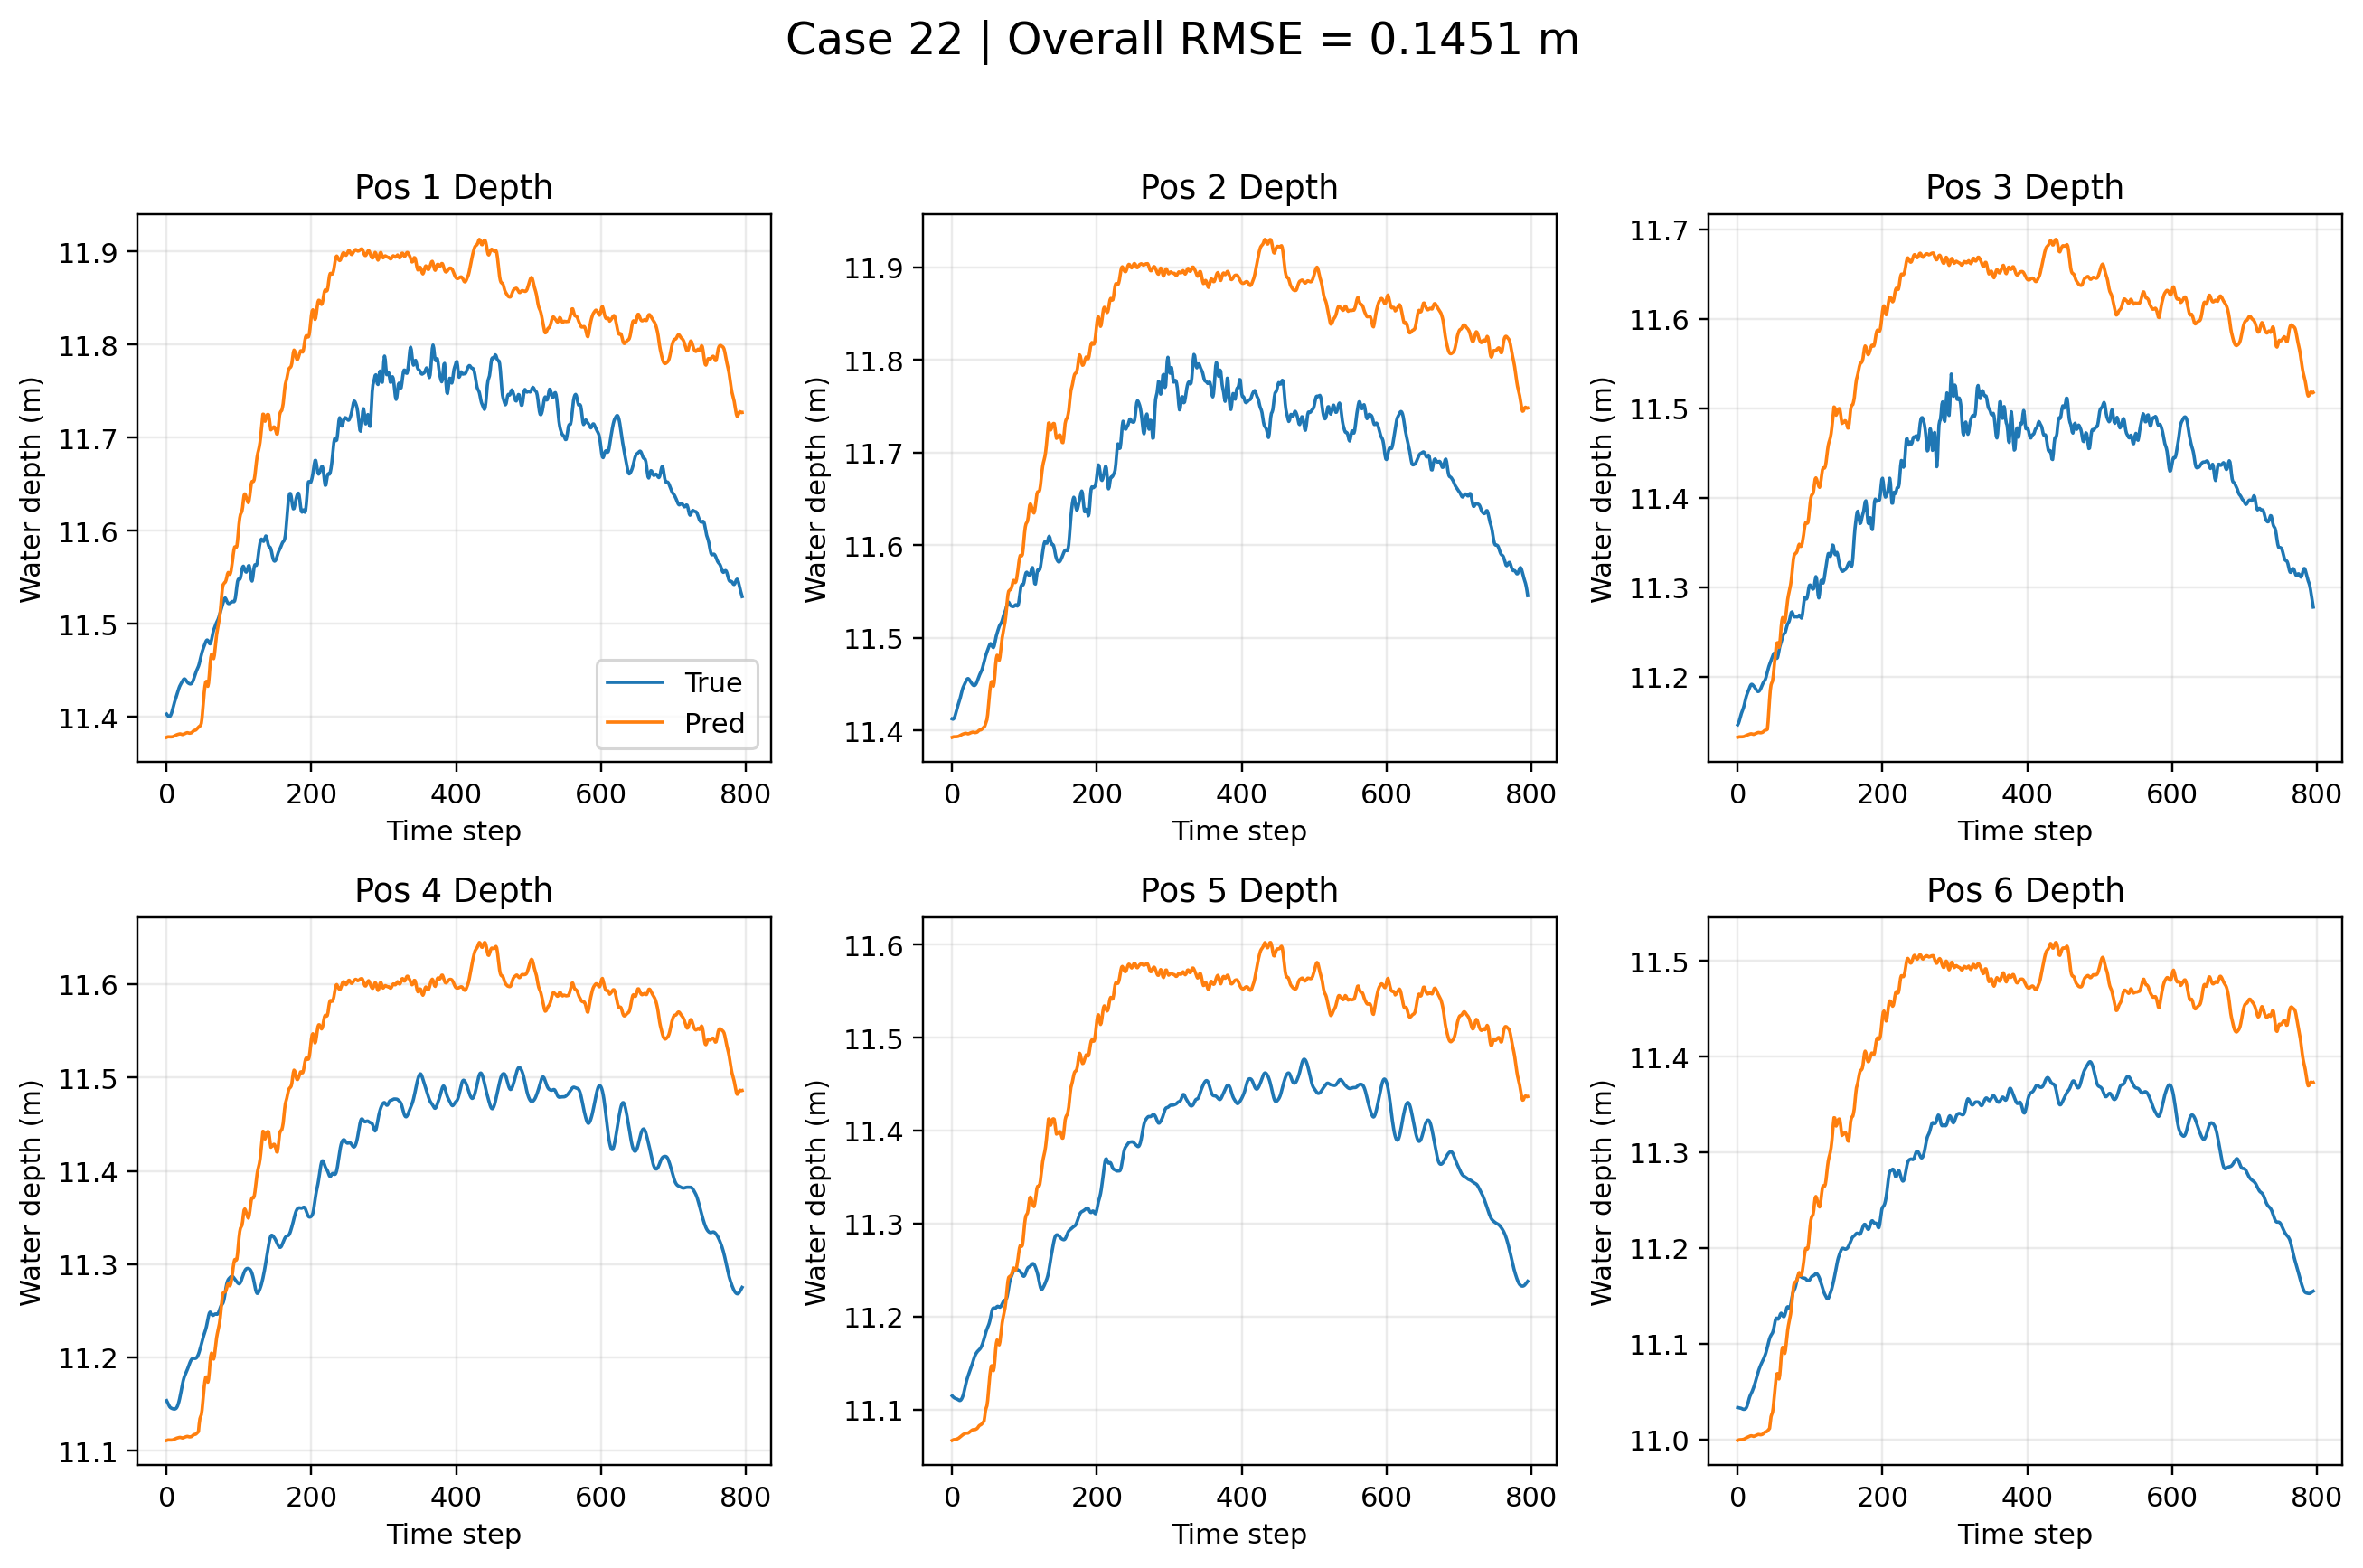

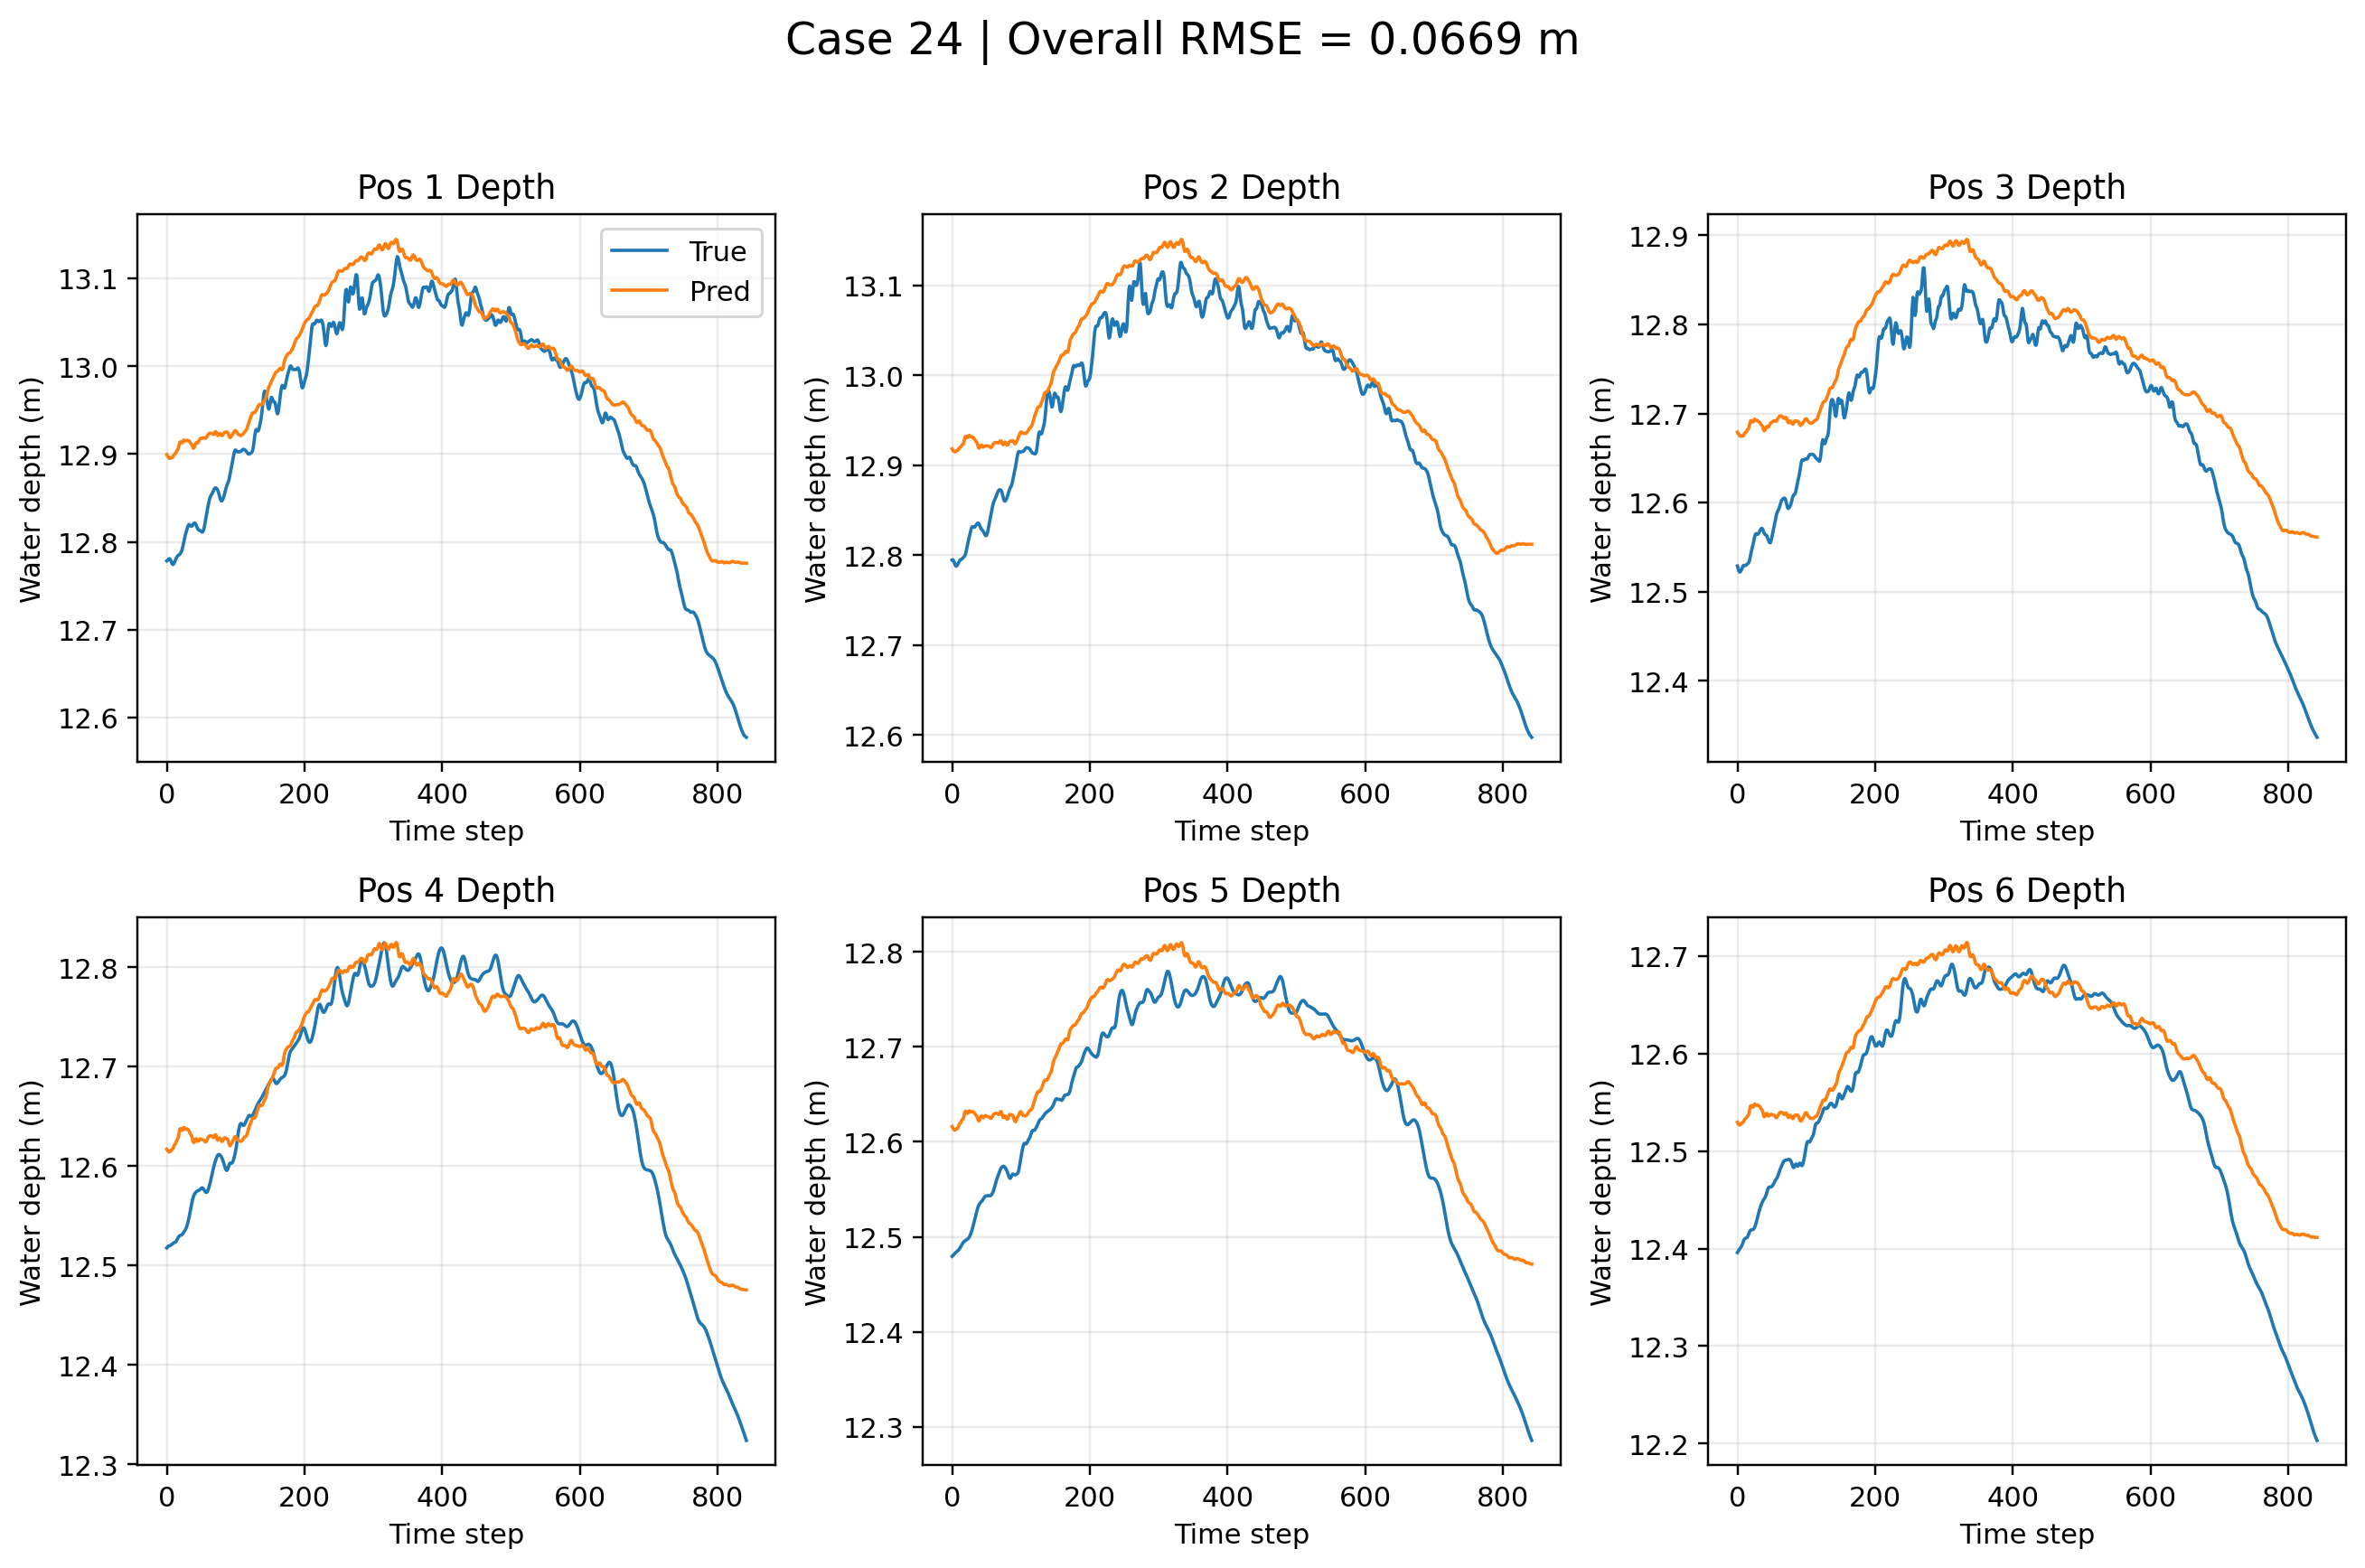

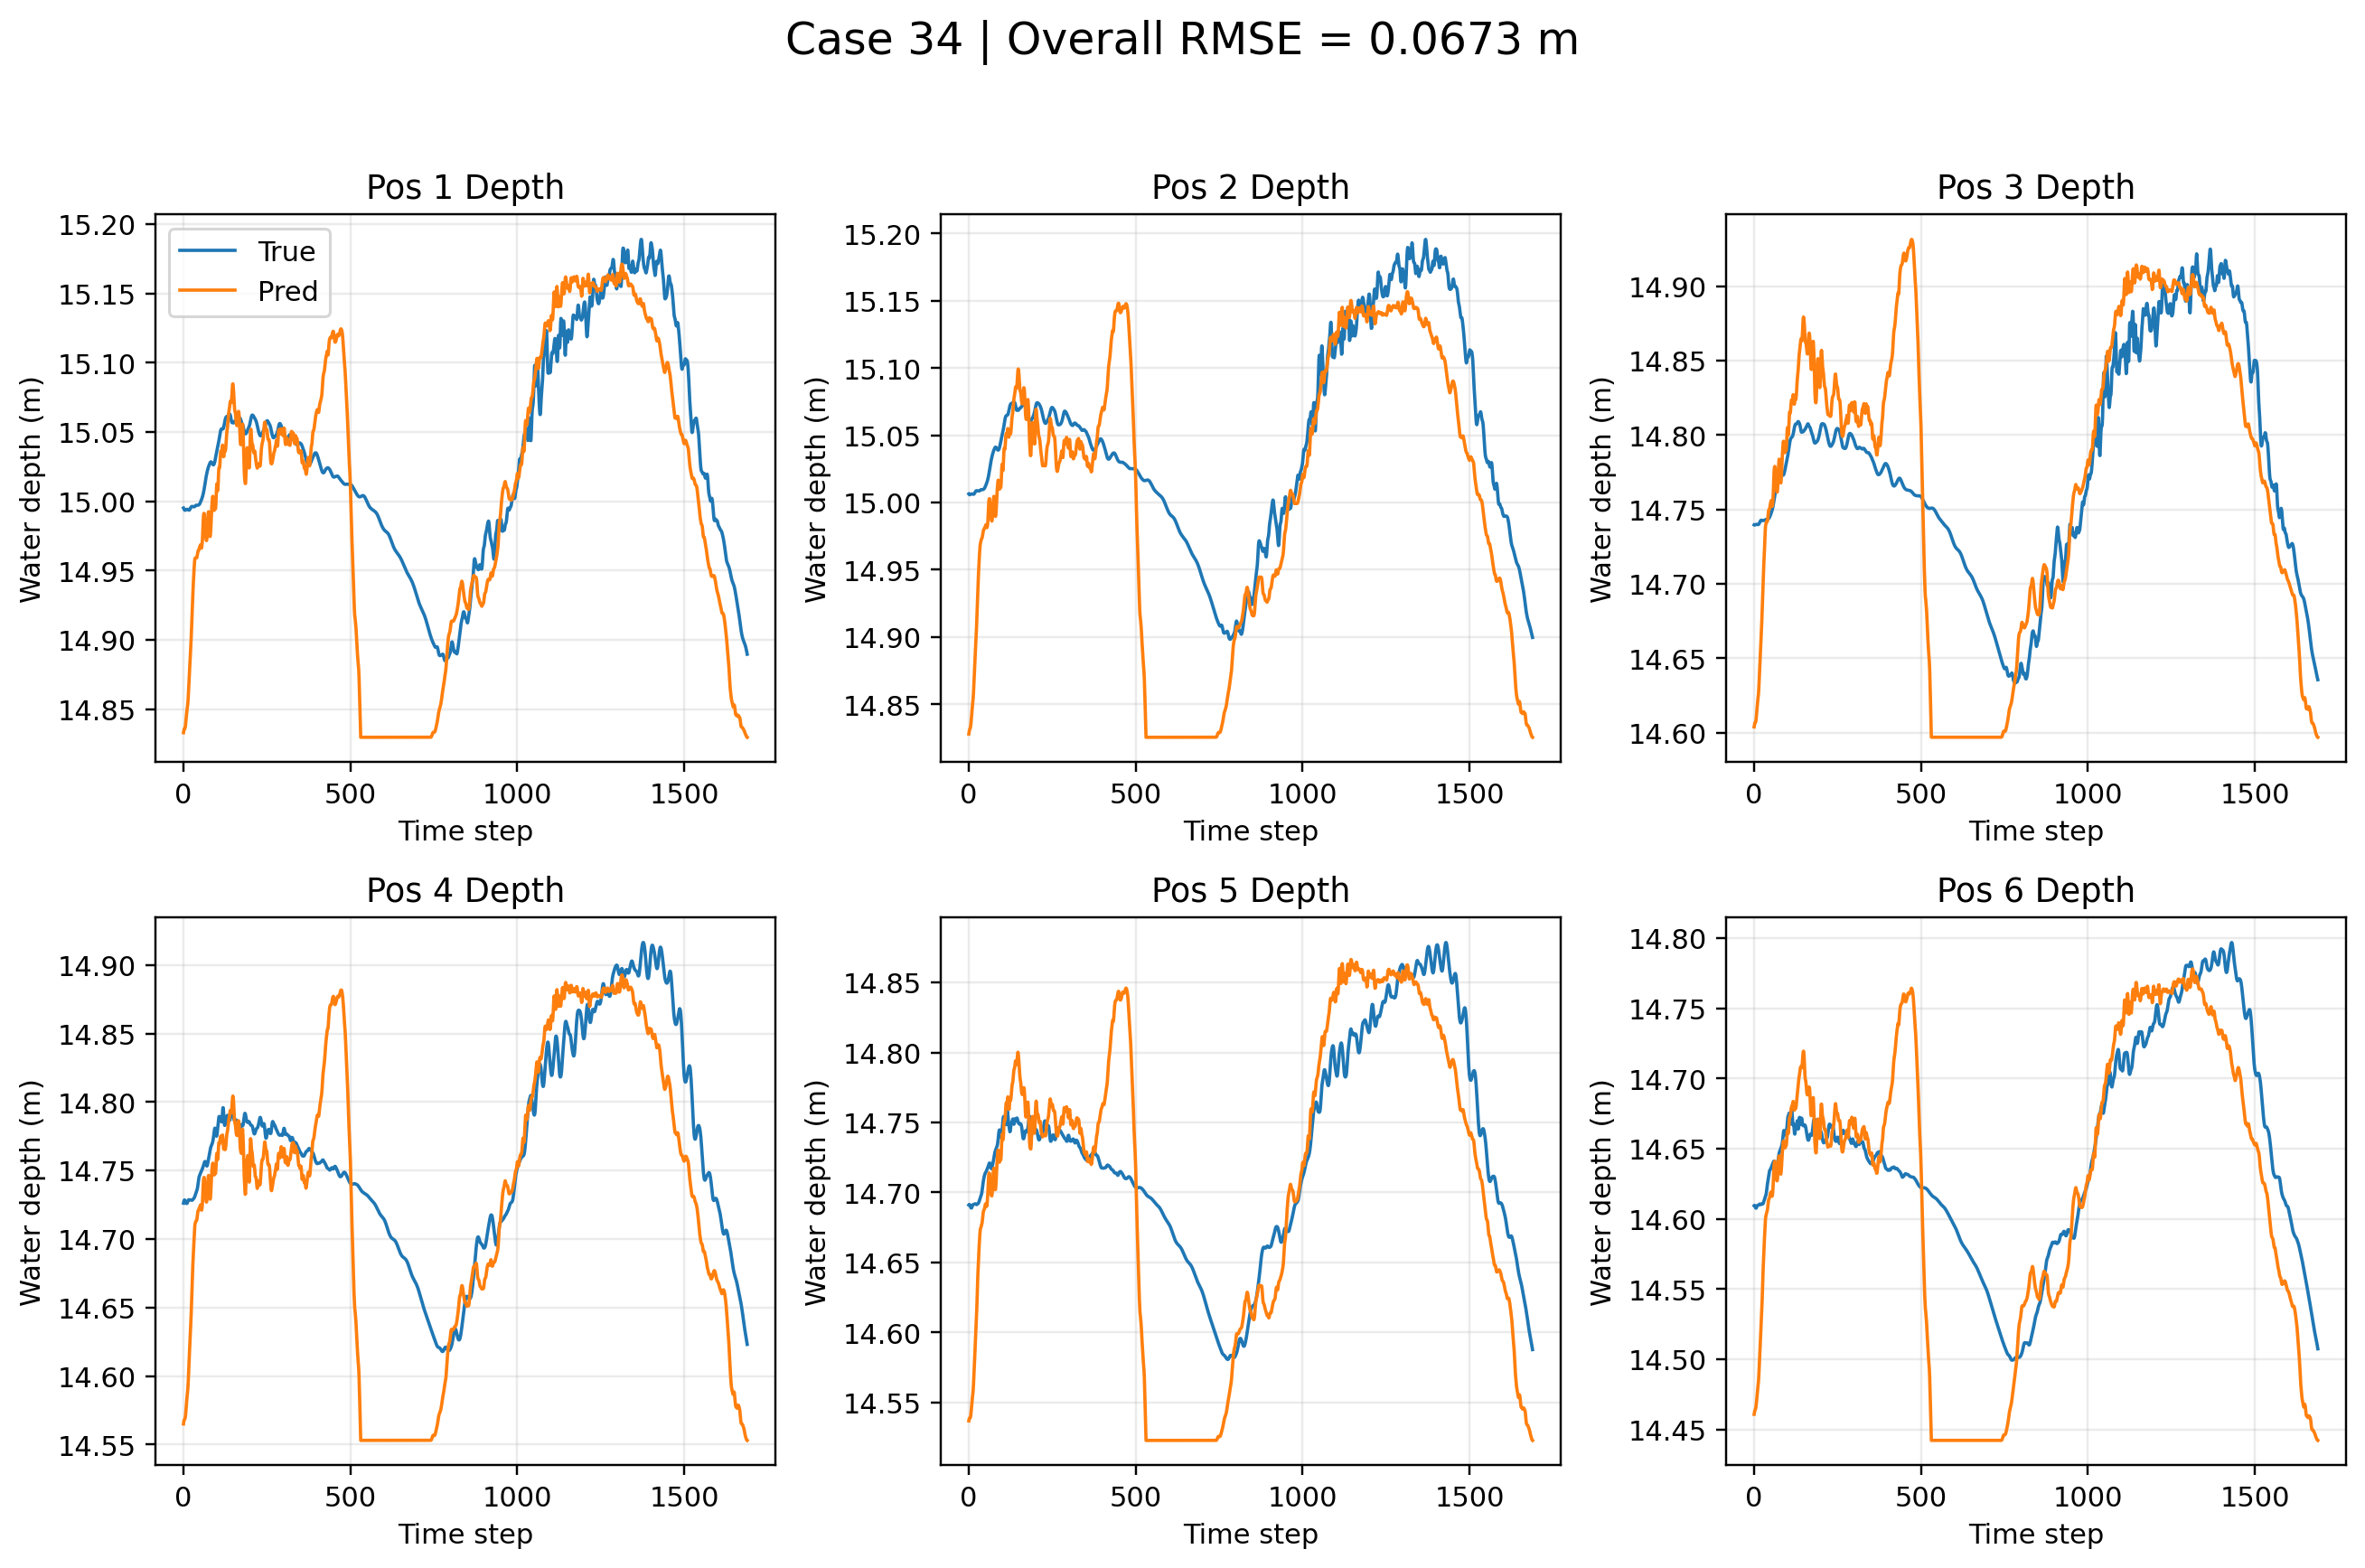

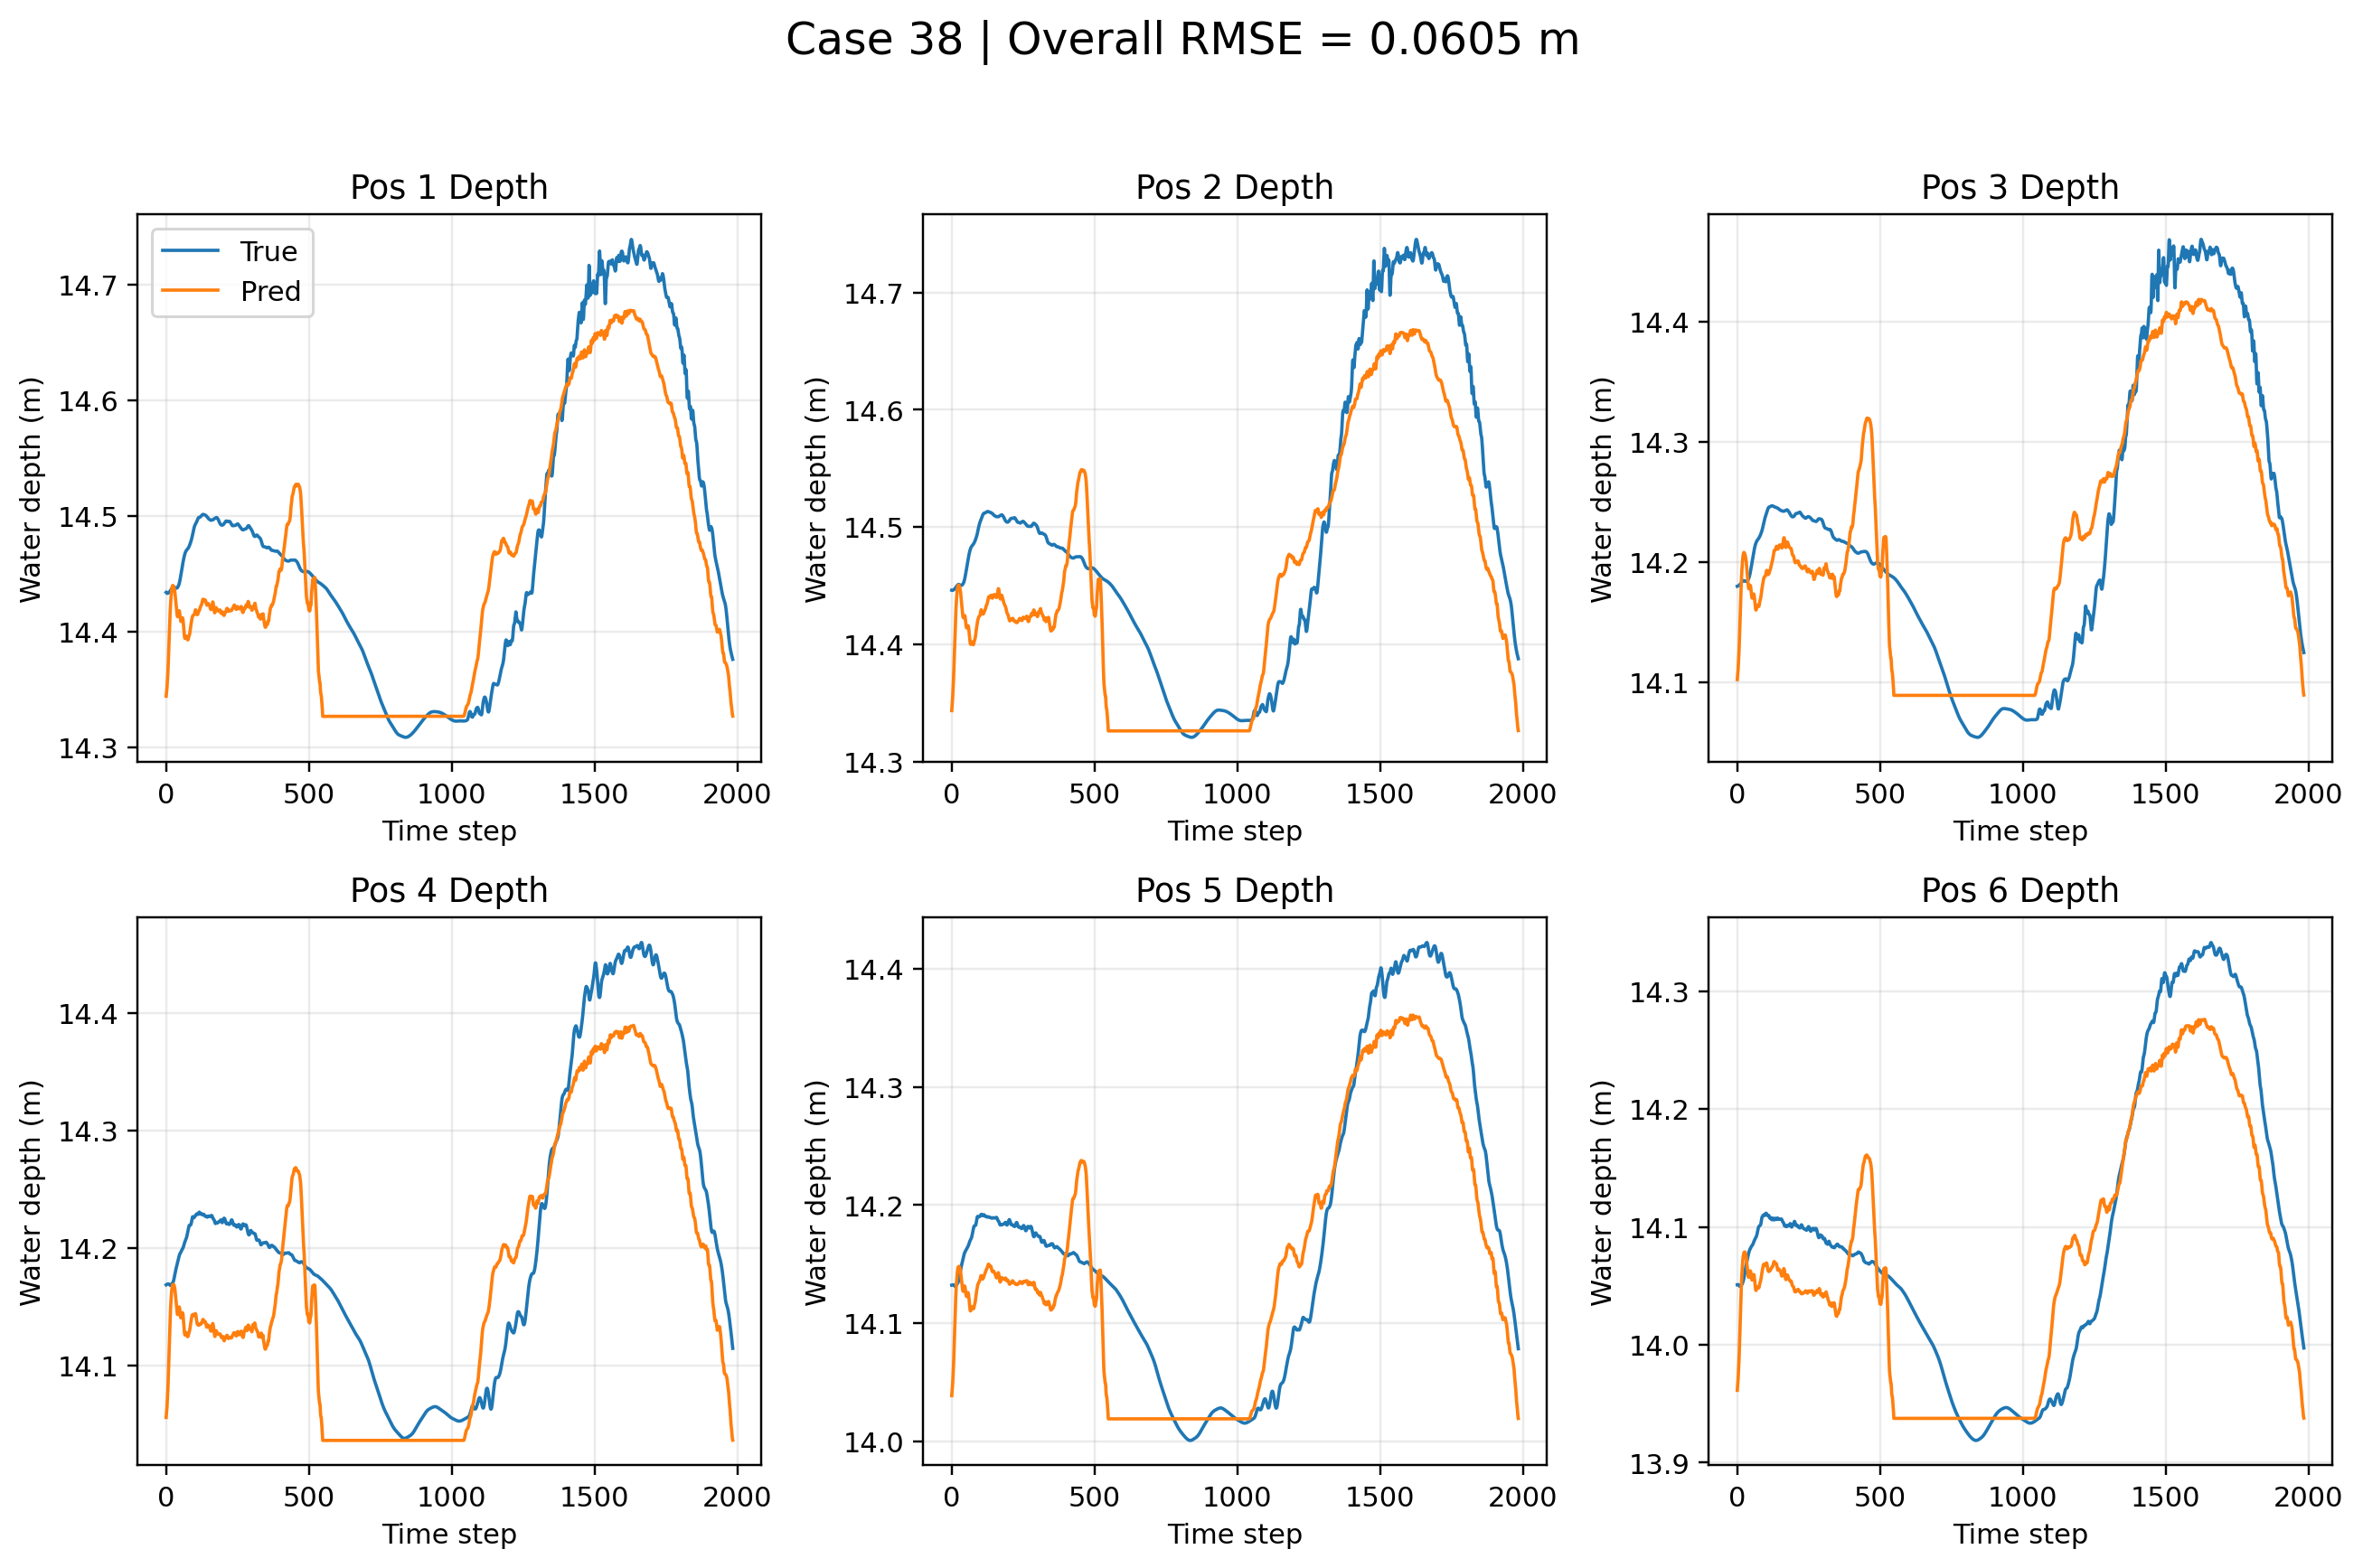

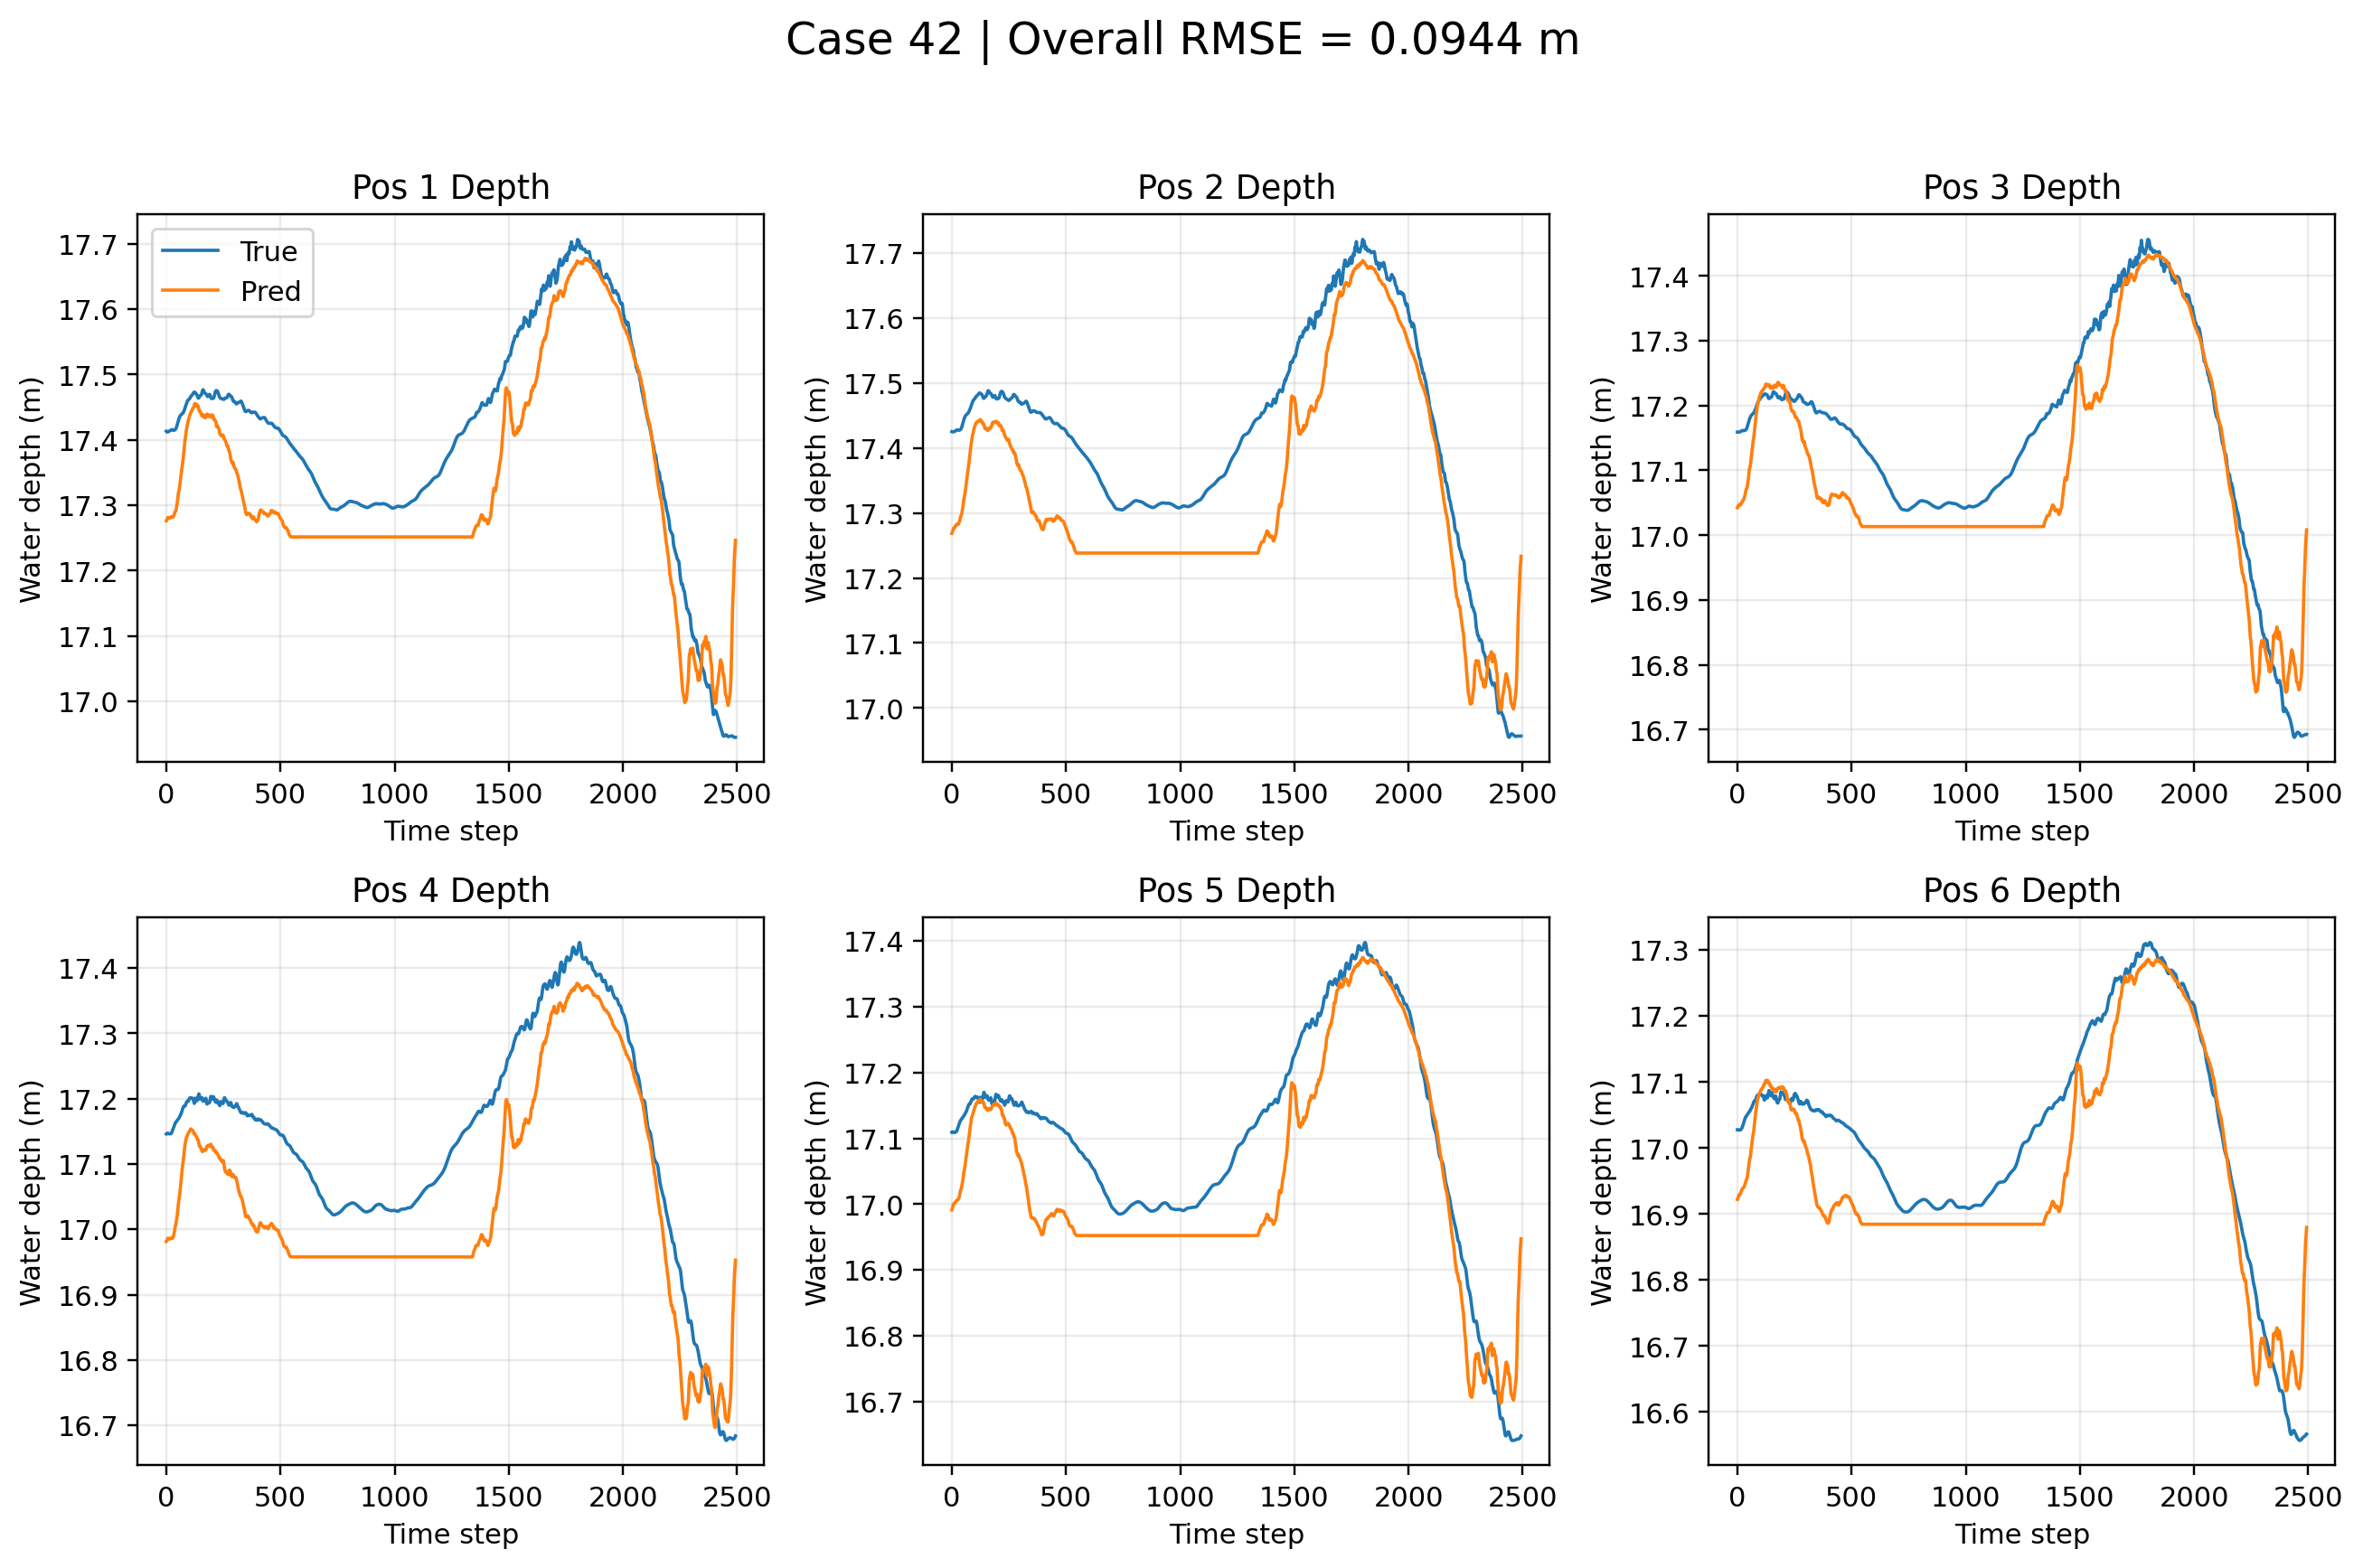

In [8]:
import matplotlib.pyplot as plt
import numpy as np

pos_names = [f"Pos {i}" for i in range(1, 7)]


for cid in sorted(test_data_per_case_norm.keys()):
    X_seq_case_norm, Y_case_norm = test_data_per_case_norm[cid]

    y_pred_case_norm = predict_norm(best_model, X_seq_case_norm, device)

    y_pred_case_real = denorm_y(y_pred_case_norm, Y_min, Y_max) 
    y_true_case_real = denorm_y(Y_case_norm, Y_min, Y_max)       

    rmse_case = float(np.sqrt(np.mean((y_pred_case_real - y_true_case_real) ** 2)))

    t = np.arange(y_true_case_real.shape[0])

    fig, axes = plt.subplots(
        2, 3,
        figsize=(12, 8),  
        dpi=220           
    )
    axes = axes.ravel()

    fig.suptitle(f"Case {cid} | Overall RMSE = {rmse_case:.4f} m", fontsize=16)

    for i in range(6):
        ax = axes[i]
        ax.plot(t, y_true_case_real[:, i], label="True", linewidth=1.2)
        ax.plot(t, y_pred_case_real[:, i], label="Pred", linewidth=1.2)

        ax.set_title(f"{pos_names[i]} Depth")
        ax.set_xlabel("Time step")
        ax.set_ylabel("Water depth (m)")
        ax.grid(True, alpha=0.25)

        if i == 0:
            ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.show()